In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from combat.pycombat import pycombat

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from pymrmre import mrmr
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore', module='pymrmre')
warnings.simplefilter(action='ignore', category=FutureWarning)

### Metabolites dataset:

File **data_zscore_comp_id.csv** contains z-score values of metabolites for each patient.

Function for loading and preprocessing data includes handling NaN values and outliers, batch effect correction and selection of subset for further analysys.


In [2]:
def data_load_preprocess():
    
    # load and drop all-NaN rows
    met_df = (pd.read_csv("./metabolomics/data_zscore_comp_id.csv"))
    met_df.set_index('Unnamed: 0', inplace=True)
    met_df.index.name = None
    met_df.dropna(axis=0, how='all', inplace=True)
    
    # drop rows containing >80% NaN
    perc = 0.8
    min_count =  int((1 - perc)*met_df.shape[1] + 1)
    met_df.dropna(axis=0, thresh=min_count, inplace=True)
    
    # fill rest of NaN values     
    met_df.fillna(0, inplace=True)
    met_df = met_df.T
    
    # batch effect correction
    clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
    met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T
    
    # drop outliers
    outliers = [17, 163, 222, 225, 255, 293, 362]
    met_df_corrected.drop(met_df_corrected.iloc[outliers].index, axis=0, inplace=True)
    
    # select patients who do not take aspirin     
    target = clin_df[['pe', 'ASA']]
    target.index = met_df.index
    df = met_df_corrected.join(target)
    df = df[df['ASA'] == False].copy(deep=True)
    df.drop(['ASA'], axis = 1, inplace=True)
    target = df['pe']
    df.drop(['pe'], axis=1, inplace=True)
    
    return df, target

In [3]:
class MRMR(BaseEstimator):
    def __init__(self, solution_length=1):
        self.solution_length = solution_length
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.solution = mrmr.mrmr_ensemble(features=X_train, 
                                           targets=pd.DataFrame(y_train), 
                                           solution_length=self.solution_length, 
                                           solution_count=1).iloc[0][0]
        return self
        
    def transform(self, X_train):
        return X_train[self.solution]

In [4]:
class KBest(BaseEstimator):
    def __init__(self, score_func = f_classif, k=100):
        self.score_func = score_func
        self.k = k
        self.solution = []
        
    def fit(self, X_train, y_train):
        self.selector = SelectKBest(score_func=self.score_func, k=self.k)
        self.selector.fit(X_train, y_train)
        return self

        
    def transform(self, X_train):
        features = self.selector.get_support(indices=True)
        new_features = X_train.columns[features]
        self.solution = new_features
        
        return X_train[new_features]
        

In [5]:
def get_best_params(pipeline, params, X, y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, 
                             scoring=['f1', 'roc_auc'], refit='f1')

    scores = cross_validate(grid, X, y, scoring=['accuracy', 'f1', 'roc_auc'],
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=47))
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [6]:
X, y = data_load_preprocess()

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/lucija/.local/lib/python3.10/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


### Finding best parameters (using grid search) for model with SelectKBest feature selector
This step is taking around 80 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:

{'fit_time': array([1006.92296648, 1007.44742203, 1012.41200638, 1008.40179944,
        1006.52522278]),
        
 'score_time': array([0.01507545, 0.01467943, 0.01476455, 0.01439404, 0.01589751]),
 
 'test_accuracy': array([0.75409836, 0.62295082, 0.75409836, 0.60655738, 0.73770492]),
 
 'test_f1': array([0.51612903, 0.37837838, 0.51612903, 0.36842105, 0.57894737]),
 
 'test_roc_auc': array([0.8283208 , 0.67669173, 0.8358396 , 0.7       , 0.75731707])}


In [7]:
params_kbest = {
    'kbest__score_func' : [f_classif, mutual_info_classif] ,
    'kbest__k' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_kbest = Pipeline([('kbest', KBest()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

# uncomment for executing grid search for best parameters:
# scores_kbest, best_params_kbest = get_best_params(model_kbest, params_kbest, X, y)


best_params_kbest = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 200,
    'kbest__k': 40,
    'kbest__score_func': f_classif
}

model_kbest.set_params(**best_params_kbest)
model_kbest.fit(X, y)

Pipeline(steps=[('kbest', KBest(k=40)), ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

### Finding best parameters (using grid search) for model with MRMR feature selector
This step is taking around 25 minutes, so best parameters are saved as dict for quick execution.

#### Scores obtained:
{'fit_time': array([307.36636376, 306.25228882, 325.61197495, 313.65118551, 306.5383637 ]),

 'score_time': array([0.01570821, 0.01510549, 0.01685596, 0.0157218 , 0.01474524]),
 
 'test_accuracy': array([0.81967213, 0.78688525, 0.78688525, 0.6557377 , 0.6557377 ]),
 
 'test_f1': array([0.66666667, 0.64864865, 0.58064516, 0.4       , 0.46153846]),
 
 'test_roc_auc': array([0.84837093, 0.88095238, 0.84837093, 0.76463415, 0.6902439 ])}


In [8]:
params_mrmr = {
    'mrmr__solution_length' : [40, 60, 80, 100, 120, 140, 160, 180, 200, 220],
    'classifier__n_estimators' : [100, 200, 500],
    'classifier__max_depth' : [10, 20, 30]
}

model_mrmr = Pipeline([('mrmr', MRMR()), ('scaler', StandardScaler()), ('classifier', XGBClassifier())])

# uncomment for executing grid search for best parameters:
# scores_mrmr, best_params_mrmr = get_best_params(model_mrmr, params_mrmr, X, y)

best_params_mrmr = {
    'classifier__max_depth': 10,
    'classifier__n_estimators': 100,
    'mrmr__solution_length': 40
}

model_mrmr.set_params(**best_params_mrmr)
model_mrmr.fit(X, y)

Pipeline(steps=[('mrmr', MRMR(solution_length=40)),
                ('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [9]:
def top_k_importances(model, k):
    importances = sorted(zip(model.steps[0][1].solution, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)
    values = [x[1] for x in importances[:k]]
    labels = [x[0] for x in importances[:k]]

    plt.bar(range(k), values)
    plt.xticks(range(k), labels=labels)
    plt.show()
    
    comp_df = pd.read_csv('./metabolomics/compAnno.csv')
    return comp_df[comp_df.COMP_ID.isin(labels)]

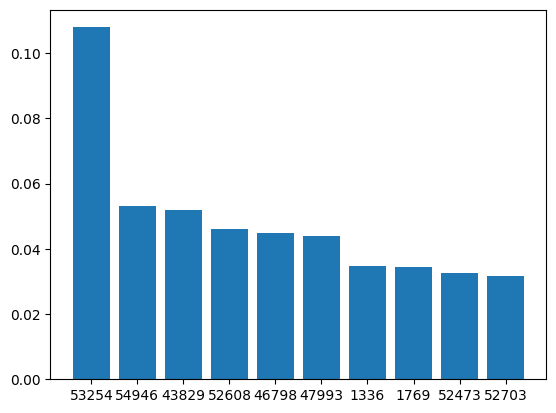

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                   cortisone             3335.0   
65                            palmitate (16:0)             1528.0   
280                       gamma-glutamylvaline              663.0   
509  oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
629                     linoleoyl ethanolamide             2200.0   
654           gamma-tocopherol/beta-tocopherol             4403.0   
692                    1-stearyl-GPC (O-18:0)*             2850.0   
710                       caffeic acid sulfate             5226.0   
722    oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   
876                                    X-17010                NaN   

              SUPER_PATHWAY                      SUB_PATHWAY  COMP_ID  \
37                    Lipid                  Corticosteroids     1769   
65                    Lipid  Long Chain Saturated Fatty Acid     1336   
280                 Peptide        Gamma-glutamyl Amino Acid    43829   
509                   Lipid                   Diacylglycerol    46798   
629                   Lipid                  Endocannabinoid    52608   
654  Cofactors and Vitamins            Tocopherol Metabolism    52473   
692                   Lipid                  Lysoplasmalogen    52703   
710             Xenobiotics             Food Component/Plant    53254   
722                   Lipid                   Diacylglycerol    54946   
876                     NaN                              NaN    47993   

      PLATFORM  CHEMICAL_ID   PUBCHEM          CAS           KEGG  \
37         Neg          273    222786      53-06-5         C00762   
65         Neg          424       985      57-10-3         C00249   
280  Pos Early    100001126   7015683    2746-34-1            NaN   
509   Pos Late    100002989  14275396  106292-55-1            NaN   
629        Neg    100006726   5283446   68171-52-8            NaN   
654   Pos Late    100008998       NaN          NaN  C14152,C02483   
692   Pos Late    100009147   2733532          NaN         C04317   
710      Polar    100009337  21668705          NaN            NaN   
722   Pos Late    100010919   9543716          NaN            NaN   
876        Neg    999917010       NaN          NaN            NaN   

                     HMDB_ID  
37               HMDB0002802  
65               HMDB0000220  
280              HMDB0011172  
509              HMDB0007219  
629              HMDB0012252  
654  HMDB0006335,HMDB0001492  
692              HMDB0011149  
710              HMDB0041708  
722              HMDB0007218  
876                      NaN

In [10]:
top_k_importances(model_kbest, 10)

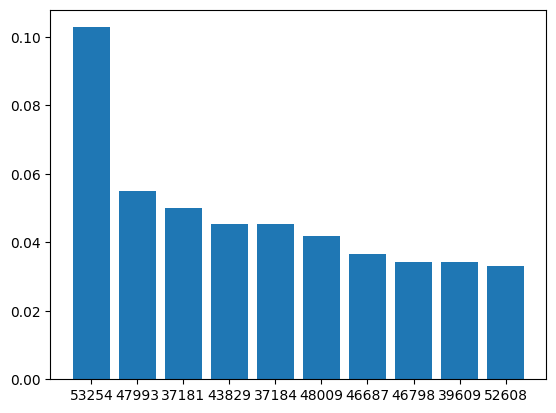

BIOCHEMICAL  PATHWAY_SORTORDER  \
280                           gamma-glutamylvaline              663.0   
429                          4-allylphenol sulfate             5111.0   
453  5alpha-androstan-3alpha,17beta-diol disulfate             3400.0   
508                            16-hydroxypalmitate             2028.0   
509      oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
629                         linoleoyl ethanolamide             2200.0   
710                           caffeic acid sulfate             5226.0   
876                                        X-17010                NaN   
882                                        X-17357                NaN   
888                                        X-18779                NaN   

    SUPER_PATHWAY                SUB_PATHWAY  COMP_ID   PLATFORM  CHEMICAL_ID  \
280       Peptide  Gamma-glutamyl Amino Acid    43829  Pos Early    100001126   
429   Xenobiotics       Food Component/Plant    37181        Neg    100001868   
453         Lipid        Androgenic Steroids    37184        Neg    100002017   
508         Lipid    Fatty Acid, Monohydroxy    39609        Neg    100002953   
509         Lipid             Diacylglycerol    46798   Pos Late    100002989   
629         Lipid            Endocannabinoid    52608        Neg    100006726   
710   Xenobiotics       Food Component/Plant    53254      Polar    100009337   
876           NaN                        NaN    47993        Neg    999917010   
882           NaN                        NaN    48009        Neg    999917357   
888           NaN                        NaN    46687        Neg    999918779   

      PUBCHEM          CAS    KEGG      HMDB_ID  
280   7015683    2746-34-1     NaN  HMDB0011172  
429  66633409          NaN     NaN          NaN  
453  56639109          NaN     NaN  HMDB0094682  
508     10466     506-13-8  C18218  HMDB0006294  
509  14275396  106292-55-1     NaN  HMDB0007219  
629   5283446   68171-52-8     NaN  HMDB0012252  
710  21668705          NaN     NaN  HMDB0041708  
876       NaN          NaN     NaN          NaN  
882       NaN          NaN     NaN          NaN  
888       NaN          NaN     NaN          NaN

In [11]:
top_k_importances(model_mrmr, 10)

### Patients dataset:

File **sampleAttr.csv** containst information on patients form 4 clinical studies. 

Loading dataset, fixing format and adding BMI column:

In [12]:
clin_df = pd.read_csv("./metabolomics/sampleAttr.csv")
clin_df['age'] = [float(x.replace(',', '.')) for x in clin_df['age']]
clin_df['weight'] = [float(x.replace(',', '.')) for x in clin_df['weight']]
clin_df['height'] = [float(x.replace(',', '.')) for x in clin_df['height']]
clin_df['smoking'] = [1 if x == 'Smoker' or x == '1' else 0 for x in clin_df.smoking]
clin_df['BMI'] = clin_df['weight'] / (clin_df['height'] / 100)**2

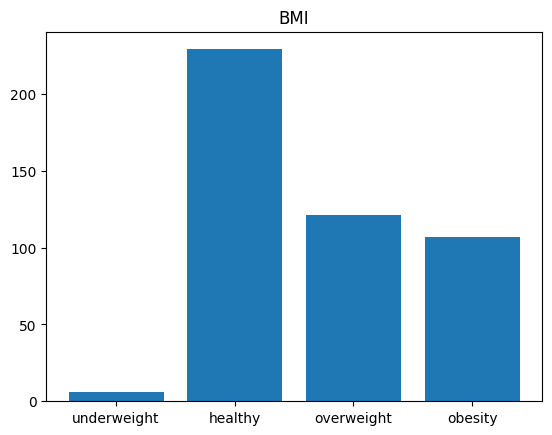

In [13]:
bmi = [clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] < 25.0].shape[0] - clin_df[clin_df['BMI'] < 18.5].shape[0], 
 clin_df[clin_df['BMI'] >= 25].shape[0] - clin_df[clin_df['BMI'] >= 30].shape[0],
 clin_df[clin_df['BMI'] >= 30].shape[0]]

plt.bar(range(4), bmi)
plt.xticks(range(4), ['underweight', 'healthy', 'overweight', 'obesity'])
plt.title('BMI')
plt.show()

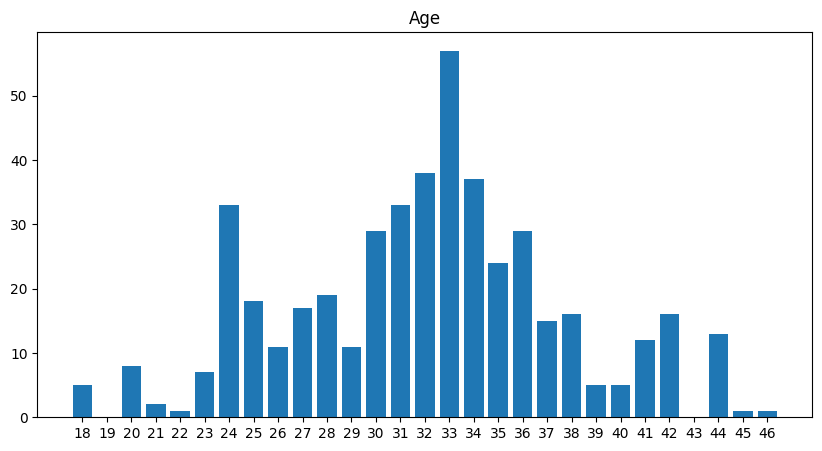

In [14]:
age = np.rint(clin_df.age).sort_values()

plt.figure(figsize=(10, 5))
plt.bar(range(18, 47), np.bincount(age)[18:])
plt.xticks(range(18, 47))
plt.title('Age')
plt.show()

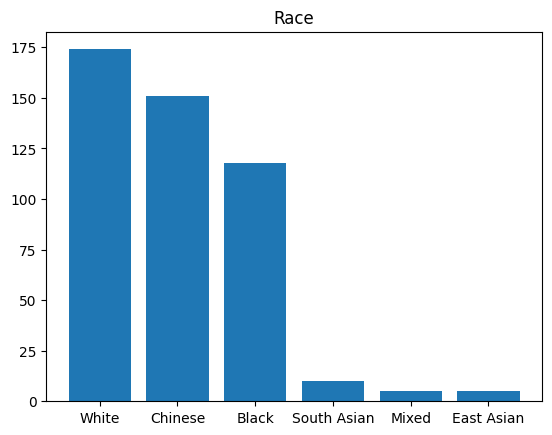

In [15]:
race = clin_df.race.value_counts()

plt.bar(range(race.shape[0]), race)
plt.xticks(range(race.shape[0]), labels=race.index)
plt.title('Race')
plt.show()

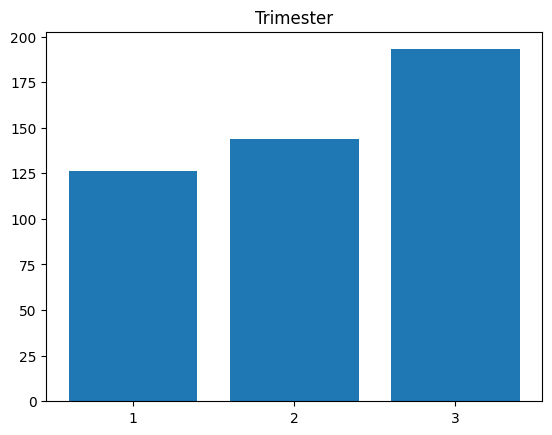

In [16]:
trimester = clin_df.trimester.value_counts().sort_index()
plt.bar(range(trimester.shape[0]), trimester)
plt.xticks(range(trimester.shape[0]), labels=trimester.index)
plt.title('Trimester')
plt.show()

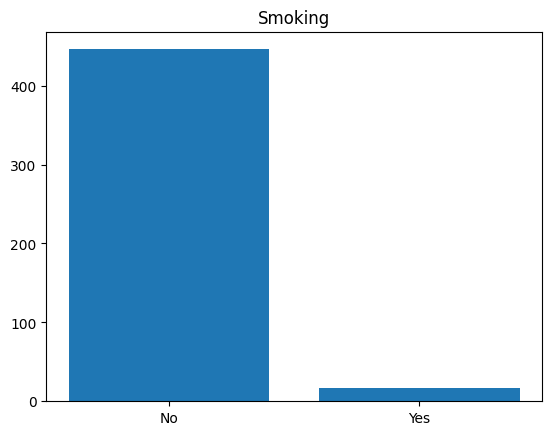

In [17]:
plt.bar([0, 1], np.bincount(clin_df.smoking))
plt.xticks([0, 1], ['No', 'Yes'])
plt.title('Smoking')
plt.show()

In [18]:
from scipy import stats

In [19]:
# get feature importances from xgb
def feature_importances(model):
    return sorted(zip(model.steps[0][1].solution, model.steps[2][1].feature_importances_), key= lambda x: x[1], reverse=True)

# apply statistics test, groups divided by preeclampsy indicator -> returns statisticaly important features
def statistics_test(test_type):
    stat_important_features = []
    test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X, on='sIDs', how='right')
    group1 = test_df[test_df.pe == 1]
    group2 = test_df[test_df.pe == 0]
    
    for metabolite in X.columns:
        t_stat, p_value = test_type(group1[metabolite], group2[metabolite])
        if p_value < 0.05:
            stat_important_features.append(metabolite)

    return stat_important_features

# intersection for both sets of impotrant features with xgb rank and importance value
def find_important_features(model, test_type):
    model_importances = feature_importances(model)
    stat_importances = statistics_test(test_type)
    
    importance_dict = {}
    v = [x[0] for x in model_importances]
    for m in stat_importances:
        if m in v:
            importance_dict[m] = (v.index(m), model_importances[v.index(m)][1])
        
    return importance_dict

In [20]:
importances_kbest = find_important_features(model_kbest, stats.mannwhitneyu)
importances_mrmr = find_important_features(model_mrmr, stats.mannwhitneyu)

In [21]:
importances_kbest

{1769: (7, 0.03434009),
 1336: (6, 0.034697052),
 57: (23, 0.01778238),
 1494: (11, 0.02963765),
 38102: (14, 0.027832966),
 38165: (10, 0.029648682),
 19263: (24, 0.017734773),
 32391: (29, 0.013047522),
 43829: (2, 0.051983546),
 32417: (26, 0.015939279),
 33959: (19, 0.020923145),
 33950: (31, 0.011280774),
 48351: (21, 0.01883528),
 34456: (37, 0.008895722),
 35428: (12, 0.02851314),
 57591: (13, 0.02796762),
 39609: (27, 0.01458024),
 46798: (4, 0.044799883),
 46799: (34, 0.010952223),
 40008: (20, 0.020085096),
 40708: (38, 0.0054972162),
 42459: (18, 0.021175463),
 48457: (15, 0.023203362),
 52608: (3, 0.045939125),
 52431: (33, 0.011021355),
 52464: (28, 0.014319696),
 53254: (0, 0.10796145),
 54942: (39, 0.0042988053),
 54945: (36, 0.009765969),
 54946: (1, 0.05322025),
 57637: (25, 0.017051632),
 62059: (17, 0.022950437),
 46266: (22, 0.018558253),
 47802: (32, 0.011152559),
 47993: (5, 0.0438561),
 48009: (16, 0.022984464)}

In [22]:
importances_mrmr

{1769: (18, 0.021466877),
 2761: (20, 0.01986863),
 19263: (28, 0.014173864),
 15500: (31, 0.012441269),
 27710: (22, 0.019332333),
 32391: (32, 0.0122821415),
 43829: (3, 0.04528157),
 33959: (13, 0.026642311),
 45095: (38, 0.0056336126),
 44664: (26, 0.015435629),
 36098: (24, 0.016750365),
 37181: (2, 0.050121903),
 57591: (35, 0.011433187),
 37200: (21, 0.019467019),
 37184: (4, 0.045229916),
 32827: (33, 0.0120367855),
 39609: (8, 0.034141336),
 46798: (7, 0.03436509),
 40008: (11, 0.029881107),
 40708: (12, 0.029446969),
 37185: (23, 0.018111805),
 48457: (25, 0.015742362),
 52608: (9, 0.03295095),
 52500: (34, 0.011717193),
 53254: (0, 0.10282458),
 57637: (27, 0.014563379),
 62059: (15, 0.023961257),
 49592: (37, 0.008207367),
 47203: (19, 0.020216523),
 47802: (36, 0.0085708145),
 46511: (16, 0.023434347),
 47993: (1, 0.05505046),
 48009: (5, 0.04189491),
 46687: (6, 0.03646195),
 46992: (10, 0.030560445),
 57720: (17, 0.023256795)}

In [32]:
# important metabolites information
comp_df = pd.read_csv('./metabolomics/compAnno.csv')
comp_df[comp_df.COMP_ID.isin(importances_kbest.keys())]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                     cortisone             3335.0   
65                              palmitate (16:0)             1528.0   
88                                     glutamate               46.0   
126                                 5-oxoproline              587.0   
152                          oleoyl ethanolamide             2177.0   
168                       palmitoyl ethanolamide             2180.0   
170         1-palmitoyl-2-oleoyl-GPE (16:0/18:1)             2426.0   
276                            1,3-dimethylurate             4618.0   
280                         gamma-glutamylvaline              663.0   
291                     docosatrienoate (22:3n3)             1582.0   
303                           N-acetyltryptophan              260.0   
304                        N-acetylphenylalanine              144.0   
347                             N1-methylinosine             4146.0   
364                    gamma-glutamylisoleucine*              654.0   
388                    tiglylcarnitine (C5:1-DC)              405.0   
438                           beta-cryptoxanthin             4456.0   
508                          16-hydroxypalmitate             2028.0   
509    oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
510    oleoyl-linoleoyl-glycerol (18:1/18:2) [2]             2946.0   
516                             isoleucylglycine              869.0   
524                   pregnanediol-3-glucuronide             3303.0   
544      sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0   
603                      4-methoxyphenol sulfate              198.0   
629                       linoleoyl ethanolamide             2200.0   
640               1-palmitoleoylglycerol (16:1)*             2871.0   
650  1-palmitoyl-2-arachidonoyl-GPE (16:0/20:4)*             2434.0   
710                         caffeic acid sulfate             5226.0   
720   palmitoyl-oleoyl-glycerol (16:0/18:1) [2]*             2924.0   
721      oleoyl-oleoyl-glycerol (18:1/18:1) [1]*             2942.0   
722      oleoyl-oleoyl-glycerol (18:1/18:1) [2]*             2943.0   
770                            carotene diol (3)             4454.0   
788                   N-acetyl-2-aminooctanoate*             1774.0   
867                                      X-15486                NaN   
871                                      X-16397                NaN   
876                                      X-17010                NaN   
882                                      X-17357                NaN   

              SUPER_PATHWAY  \
37                    Lipid   
65                    Lipid   
88               Amino Acid   
126              Amino Acid   
152                   Lipid   
168                   Lipid   
170                   Lipid   
276             Xenobiotics   
280                 Peptide   
291                   Lipid   
303              Amino Acid   
304              Amino Acid   
347              Nucleotide   
364                 Peptide   
388              Amino Acid   
438  Cofactors and Vitamins   
508                   Lipid   
509                   Lipid   
510                   Lipid   
516                 Peptide   
524                   Lipid   
544                   Lipid   
603              Amino Acid   
629                   Lipid   
640                   Lipid   
650                   Lipid   
710             Xenobiotics   
720                   Lipid   
721                   Lipid   
722                   Lipid   
770  Cofactors and Vitamins   
788                   Lipid   
867                     NaN   
871                     NaN   
876                     NaN   
882                     NaN   

                                           SUB_PATHWAY  COMP_ID   PLATFORM  \
37                                     Corticosteroids     1769        Neg   
65                     Long Chain Saturated Fatty Acid     1336        Neg   
88                         

In [34]:
comp_df[comp_df.COMP_ID.isin(importances_mrmr.keys())]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                           cortisone             3335.0   
139                                          thyroxine              250.0   
170               1-palmitoyl-2-oleoyl-GPE (16:0/18:1)             2426.0   
186                                          carnitine             1950.0   
259                                    N-acetylglycine                2.0   
276                                  1,3-dimethylurate             4618.0   
280                               gamma-glutamylvaline              663.0   
303                                 N-acetyltryptophan              260.0   
366                      2-methylbutyrylcarnitine (C5)              402.0   
386                          glutarylcarnitine (C5-DC)              129.0   
412                              4-vinylphenol sulfate             4547.0   
429                              4-allylphenol sulfate             5111.0   
438                                 beta-cryptoxanthin             4456.0   
451  5alpha-pregnan-3beta,20alpha-diol monosulfate (2)             3294.0   
453      5alpha-androstan-3alpha,17beta-diol disulfate             3400.0   
471           andro steroid monosulfate C19H28O6S (1)*             3413.0   
508                                16-hydroxypalmitate             2028.0   
509          oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
516                                   isoleucylglycine              869.0   
524                         pregnanediol-3-glucuronide             3303.0   
581  5alpha-androstan-3alpha,17beta-diol monosulfat...             3399.0   
603                            4-methoxyphenol sulfate              198.0   
629                             linoleoyl ethanolamide             2200.0   
673           1-margaroyl-2-linoleoyl-GPC (17:0/18:2)*             2335.0   
710                               caffeic acid sulfate             5226.0   
770                                  carotene diol (3)             4454.0   
788                         N-acetyl-2-aminooctanoate*             1774.0   
814                                            X-11315                NaN   
856                                            X-13007                NaN   
871                                            X-16397                NaN   
875                                            X-16938                NaN   
876                                            X-17010                NaN   
882                                            X-17357                NaN   
888                                            X-18779                NaN   
919                                            X-21815                NaN   
961                                            X-24953                NaN   

              SUPER_PATHWAY                                SUB_PATHWAY  \
37                    Lipid                            Corticosteroids   
139              Amino Acid                        Tyrosine Metabolism   
170                   Lipid              Phosphatidylethanolamine (PE)   
186                   Lipid                       Carnitine Metabolism   
259              Amino Acid   Glycine, Serine and Threonine Metabolism   
276             Xenobiotics                        Xanthine Metabolism   
280                 Peptide                  Gamma-glutamyl Amino Acid   
303              Amino Acid                      Tryptophan Metabolism   
366              Amino Acid  Leucine, Isoleucine and Valine Metabolism   
386              Amino Acid                          Lysine Metabolism   
412             Xenobiotics                        Benzoate Metabolism   
429             Xenobiotics                       Food Component/Plant   
438  Cofactors and Vitamins                       Vitamin A Metabolism   
451                   Lipid                         Progestin Steroids   
453                   Lipid                        Androgenic Steroids   
471      

In [36]:
importances_intersect = [x for x in importances_kbest.keys() if x in importances_mrmr.keys()]

In [40]:
comp_df[comp_df.COMP_ID.isin(importances_intersect)]

BIOCHEMICAL  PATHWAY_SORTORDER  \
37                                   cortisone             3335.0   
170       1-palmitoyl-2-oleoyl-GPE (16:0/18:1)             2426.0   
276                          1,3-dimethylurate             4618.0   
280                       gamma-glutamylvaline              663.0   
303                         N-acetyltryptophan              260.0   
438                         beta-cryptoxanthin             4456.0   
508                        16-hydroxypalmitate             2028.0   
509  oleoyl-linoleoyl-glycerol (18:1/18:2) [1]             2945.0   
516                           isoleucylglycine              869.0   
524                 pregnanediol-3-glucuronide             3303.0   
603                    4-methoxyphenol sulfate              198.0   
629                     linoleoyl ethanolamide             2200.0   
710                       caffeic acid sulfate             5226.0   
770                          carotene diol (3)             4454.0   
788                 N-acetyl-2-aminooctanoate*             1774.0   
871                                    X-16397                NaN   
876                                    X-17010                NaN   
882                                    X-17357                NaN   

              SUPER_PATHWAY                    SUB_PATHWAY  COMP_ID  \
37                    Lipid                Corticosteroids     1769   
170                   Lipid  Phosphatidylethanolamine (PE)    19263   
276             Xenobiotics            Xanthine Metabolism    32391   
280                 Peptide      Gamma-glutamyl Amino Acid    43829   
303              Amino Acid          Tryptophan Metabolism    33959   
438  Cofactors and Vitamins           Vitamin A Metabolism    57591   
508                   Lipid        Fatty Acid, Monohydroxy    39609   
509                   Lipid                 Diacylglycerol    46798   
516                 Peptide                      Dipeptide    40008   
524                   Lipid             Progestin Steroids    40708   
603              Amino Acid            Tyrosine Metabolism    48457   
629                   Lipid                Endocannabinoid    52608   
710             Xenobiotics           Food Component/Plant    53254   
770  Cofactors and Vitamins           Vitamin A Metabolism    57637   
788                   Lipid              Fatty Acid, Amino    62059   
871                     NaN                            NaN    47802   
876                     NaN                            NaN    47993   
882                     NaN                            NaN    48009   

      PLATFORM  CHEMICAL_ID        PUBCHEM          CAS    KEGG      HMDB_ID  
37         Neg          273         222786      53-06-5  C00762  HMDB0002802  
170   Pos Late         1526        5283496   26662-94-2     NaN  HMDB0005320  
276        Neg    100001106          70346     944-73-0     NaN  HMDB0001857  
280  Pos Early    100001126        7015683    2746-34-1     NaN  HMDB0011172  
303        Neg    100001254  439917,700653    1218-34-4  C03137  HMDB0013713  
438   Pos Late    100001977        5281235     472-70-8  C08591  HMDB0033844  
508        Neg    100002953          10466     506-13-8  C18218  HMDB0006294  
509   Pos Late    100002989       14275396  106292-55-1     NaN  HMDB0007219  
516        Neg    100003169         342532     868-28-0     NaN  HMDB0028907  
524        Neg    100003470         123796    1852-49-9     NaN  HMDB0010318  
603        Neg    100006262            NaN    3233-60-1     NaN          NaN  
629        Neg    100006726        5283446   68171-52-8     NaN  HMDB0012252  
710      Polar    100009337       21668705          NaN     NaN  HMDB0041708  
770   Pos Late    100015968            NaN          NaN     NaN          NaN  
788        Neg    100020204          95555          NaN     NaN  HMDB0059745  
871  Pos Early    999916397            NaN          NaN     NaN          NaN  
876        Neg    999917010   

In [24]:
test = clin_df[['trimester', 'sIDs', 'pe']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
group0 = test[test.pe == 0].drop('pe', axis = 1).groupby('trimester')
group1 = test[test.pe == 1].drop('pe', axis = 1).groupby('trimester')

In [25]:
group0.agg(['mean', 'median', 'std'])

1769                          2761                       \
               mean    median       std      mean    median       std   
trimester                                                               
1         -0.108232 -0.151124  0.499618  0.114192  0.127919  0.573469   
2          0.206447  0.159592  0.581871  0.205141  0.256389  0.535350   
3          0.380863  0.443684  0.572690  0.257088  0.121604  0.760339   

              19263                         15500  ...     48009     46687  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1          0.204404  0.145755  0.280172  0.142301  ...  0.543002  0.003511   
2          0.732698  0.710725  0.341625 -0.704627  ...  0.495762 -0.084443   
3          0.686527  0.705239  0.634571 -0.659660  ...  0.738747 -0.124235   

                                  46992                         57720  \
             median       std      mean    median       std      mean   
trimester                                                               
1         -0.067059  0.851155  0.006128  0.051279  0.351355  0.145496   
2         -0.204367  0.693359  0.216245  0.072381  0.757265  0.033873   
3         -0.252252  0.811286  0.122558  0.046437  0.674537 -0.139430   

                               
             median       std  
trimester                      
1          0.104312  0.888713  
2          0.152489  0.880995  
3         -0.222080  0.722475  

[3 rows x 108 columns]

In [26]:
group1.agg(['mean', 'median', 'std'])

1769                          2761                       \
               mean    median       std      mean    median       std   
trimester                                                               
1          0.392667  0.571275  0.917684  0.241592  0.154482  0.468755   
2          0.402860  0.468222  0.900877  0.036704  0.020787  0.515688   
3          0.549183  0.399884  0.649591 -0.076788 -0.112596  0.922721   

              19263                         15500  ...     48009     46687  \
               mean    median       std      mean  ...       std      mean   
trimester                                          ...                       
1          0.364142  0.417179  0.401637 -0.322886  ...  0.295512 -0.179472   
2          0.916740  0.890981  0.352560 -0.996119  ...  0.401592 -0.296199   
3          0.867280  0.939943  0.697522 -0.673126  ...  0.800359 -0.303369   

                                  46992                         57720  \
             median       std      mean    median       std      mean   
trimester                                                               
1         -0.100164  0.678551 -0.099578 -0.425683  0.457035  0.220165   
2         -0.170131  0.837915 -0.003279 -0.425683  0.593327  0.107916   
3         -0.470110  0.907796 -0.065752 -0.113199  0.361604  0.310342   

                               
             median       std  
trimester                      
1          0.222455  0.731996  
2         -0.082293  0.790872  
3         -0.031788  1.023725  

[3 rows x 108 columns]

In [27]:
mean_values0 = group0.agg('mean')
mean_values1 = group1.agg('mean')

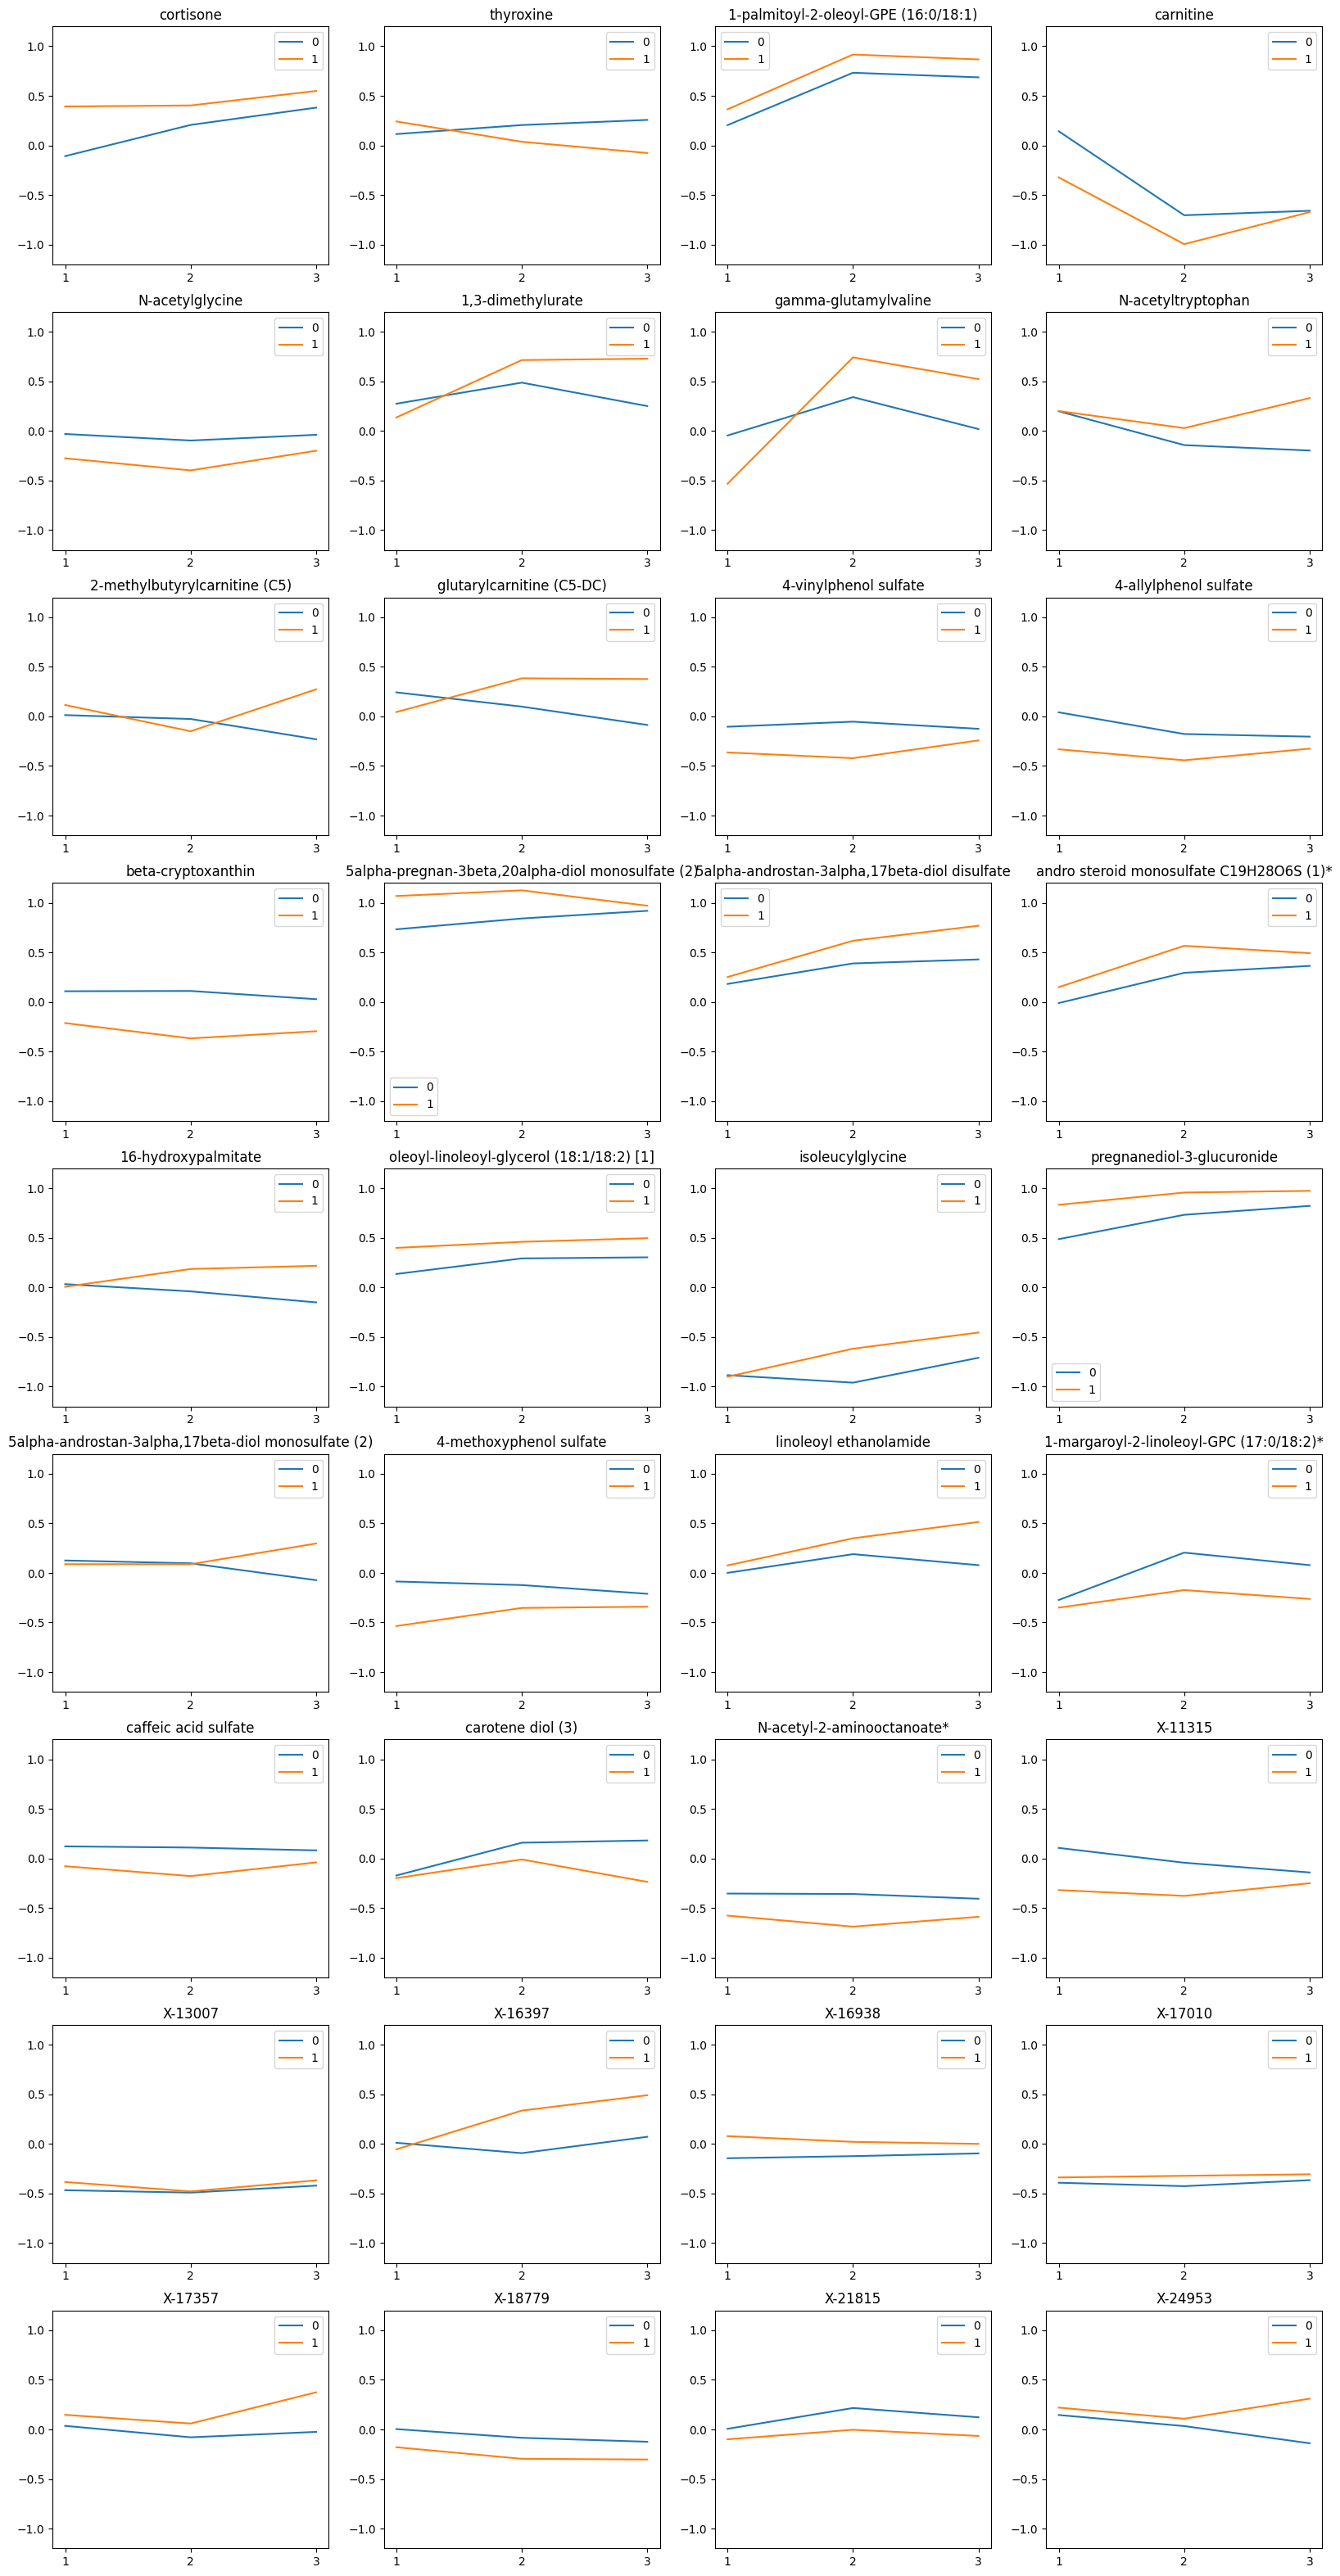

In [28]:
# promena koncentracije tokom trimestara
i = 1
plt.figure(figsize=(20, 40))
for m in importances_mrmr.keys():
    plt.subplot(9, 4, i)
    plt.plot(mean_values0.index, mean_values0[m])
    plt.plot(mean_values1.index, mean_values1[m])
    
    plt.xticks(mean_values0.index)
    plt.legend(['0', '1'])
    plt.ylim(-1.2, 1.2)
    
    [name] = comp_df[comp_df.COMP_ID == m].BIOCHEMICAL
    plt.title(name)
    
    
    i += 1
    
    
plt.show()

In [41]:
def bmi_categories(row):
    if row.BMI < 18.5:
        return 1
    elif row.BMI < 25.0:
        return 2
    elif row.BMI < 30.0:
        return 3
    else:
        return 4


In [42]:
test_bmi = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')
test_bmi['BMI'] = test_bmi.apply(bmi_categories, axis=1)

group_bmi2 = test_bmi[test_bmi.BMI == 2]
group0_bmi2 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1)
group1_bmi2 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1)

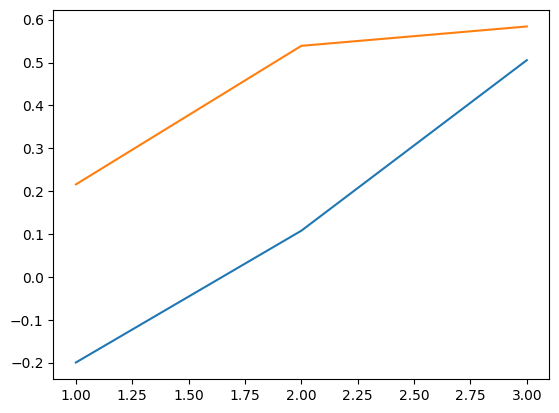

In [44]:
mean_02 = group0_bmi2.groupby('trimester').agg('mean')
mean_12 = group1_bmi2.groupby('trimester').agg('mean')

plt.plot(mean_02.index, mean_02[1769])
plt.plot(mean_12.index, mean_12[1769])

In [45]:
# no patients from bmi category 1:
test_bmi.BMI.value_counts()

2    140
4     84
3     81
Name: BMI, dtype: int64

In [47]:
stats.mannwhitneyu(group0_bmi2[group0_bmi2.trimester == 3][1769], group1_bmi2[group1_bmi2.trimester == 3][1769])

MannwhitneyuResult(statistic=256.0, pvalue=0.7496791566693759)

In [48]:
for bmi in range(2, 5):
    group_bmi2 = test_bmi[test_bmi.BMI == bmi]
    group0_bmi2 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1)
    group1_bmi2 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1)

    for m in importances_mrmr.keys():
        for t in range(1, 4):
            s, p = stats.mannwhitneyu(group0_bmi2[group0_bmi2.trimester == t][m], group1_bmi2[group1_bmi2.trimester == t][m])
            if p < 0.05:
                print(f'met: {m}, bmi: {bmi}, trim: {t}, p-val: {p}')

met: 19263, bmi: 2, trim: 1, p-val: 0.027306658885606253
met: 15500, bmi: 2, trim: 2, p-val: 0.010952956902854997
met: 43829, bmi: 2, trim: 1, p-val: 0.040923514607725135
met: 43829, bmi: 2, trim: 3, p-val: 0.028350442542573275
met: 33959, bmi: 2, trim: 3, p-val: 0.013898790326539213
met: 45095, bmi: 2, trim: 3, p-val: 0.005995013261214116
met: 44664, bmi: 2, trim: 3, p-val: 0.04054284662909363
met: 57591, bmi: 2, trim: 2, p-val: 0.008527440725824597
met: 37200, bmi: 2, trim: 2, p-val: 0.003862579041647307
met: 39609, bmi: 2, trim: 3, p-val: 0.00021993090498528166
met: 46798, bmi: 2, trim: 1, p-val: 0.011138552021878302
met: 40708, bmi: 2, trim: 1, p-val: 0.004717267875162612
met: 40708, bmi: 2, trim: 2, p-val: 0.000657689004137086
met: 40708, bmi: 2, trim: 3, p-val: 0.020570510375277816
met: 53254, bmi: 2, trim: 2, p-val: 0.014774042392111532
met: 57637, bmi: 2, trim: 3, p-val: 0.0067917848909620155
met: 47802, bmi: 2, trim: 3, p-val: 0.025125158144259543
met: 46511, bmi: 2, trim: 1, 

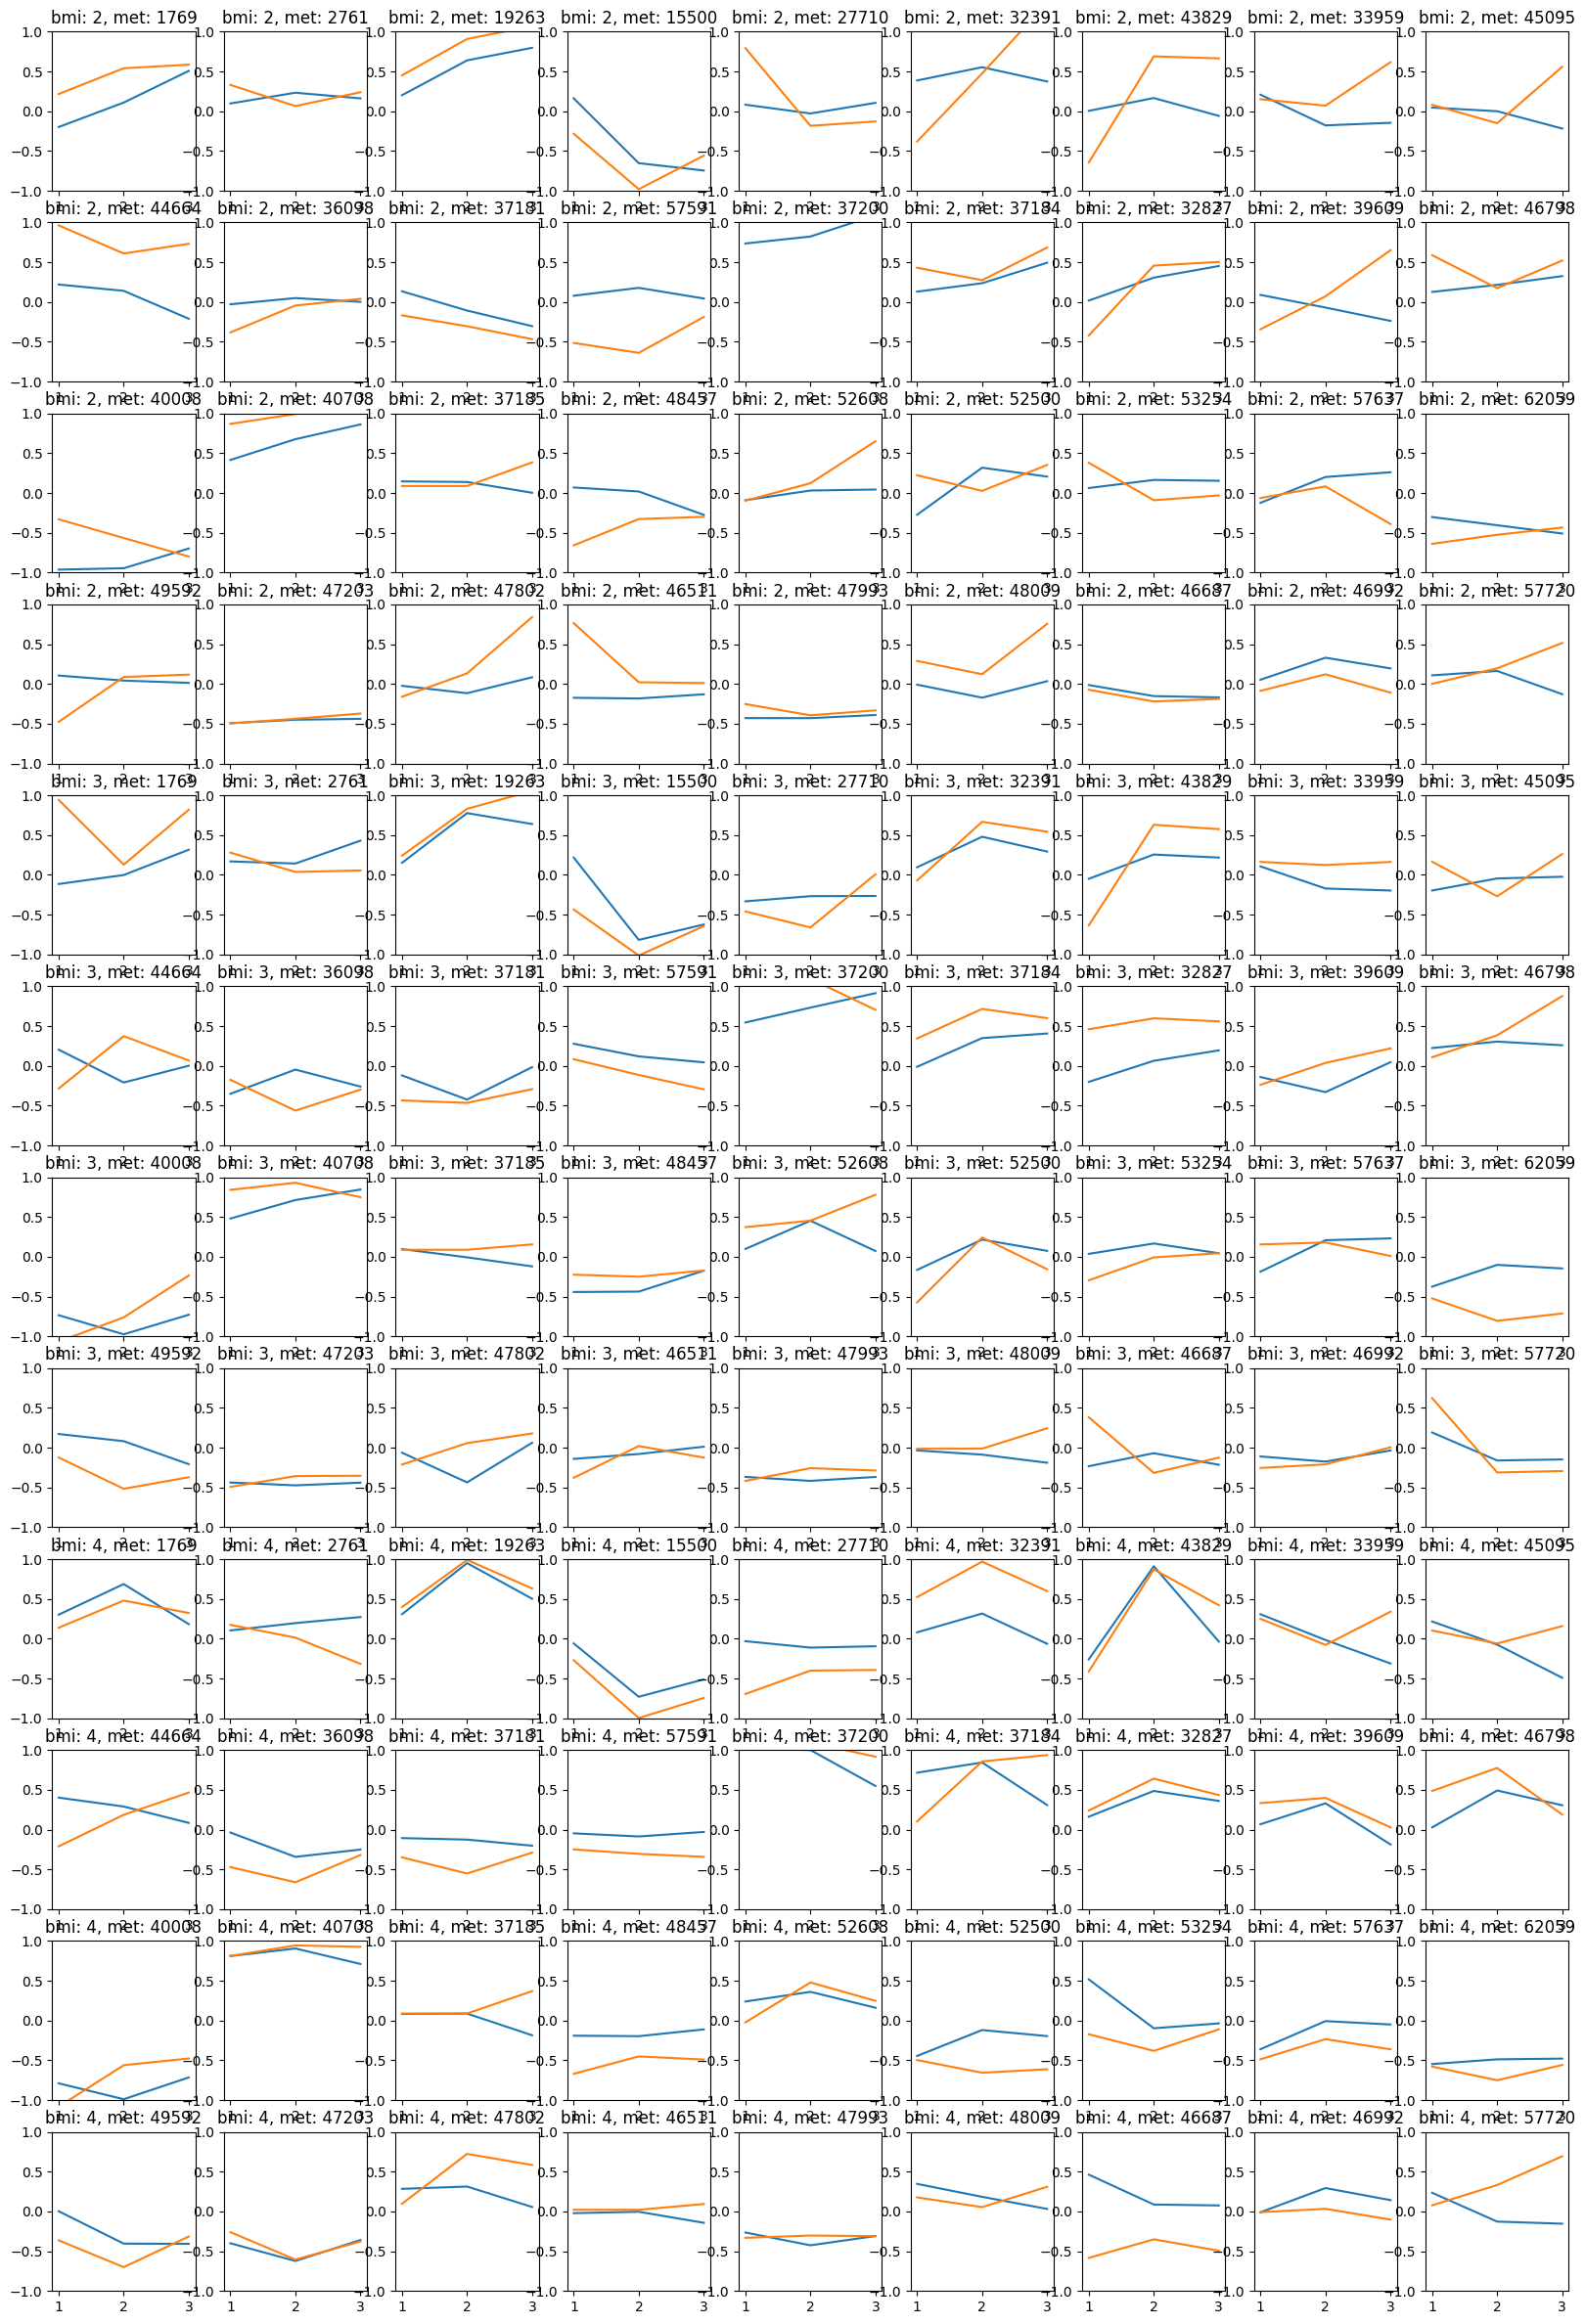

In [53]:
# promena koncentracija tokom trimestara, u odnosu na bmi
i = 1
plt.figure(figsize=(20, 30))
for bmi in range(2, 5):
    group_bmi2 = test_bmi[test_bmi.BMI == bmi]
    mean_02 = group_bmi2[group_bmi2.pe == 0].drop('pe', axis = 1).groupby('trimester').agg('mean')
    mean_12 = group_bmi2[group_bmi2.pe == 1].drop('pe', axis = 1).groupby('trimester').agg('mean')
    
    for m in importances_mrmr.keys():
        plt.subplot(12, 9, i)
        plt.plot(mean_02.index, mean_02[m])
        plt.plot(mean_12.index, mean_12[m])
        plt.title(f'bmi: {bmi}, met: {m}')
        plt.ylim(-1, 1)
        i += 1
        
plt.show()

In [54]:
# T test -> Assumptions of normal distribution
# Shapiro test -> test for normal distribution in data (0-hypothesis: data is not from normal distribution)

In [55]:
def check_normal_distribution():
    normal = []
    for metabolite in X.columns:
        s, p = stats.shapiro(X[metabolite])
        if p > 0.05:
            normal.append(metabolite)
            
    return normal

In [56]:
normal_distr_features = check_normal_distribution()

In [57]:
test_df = clin_df[['trimester', 'sIDs', 'pe']].join(X[normal_distr_features], on='sIDs', how='right')
group1 = test_df[test_df.pe == 1]
group2 = test_df[test_df.pe == 0]

t_test_res = []
for m in normal_distr_features:
    t, p = stats.ttest_ind(group1[m], group2[m])
    if p < 0.05:
        t_test_res.append(m)

In [58]:
t_test_res

[1769, 54, 15506, 52461, 42459, 52500]

In [63]:
proba = feature_importances(model_kbest)
proba = [x[0] for x in proba]
res = []
for m in t_test_res:
    if m in proba:
        res.append(m)

In [64]:
comp_df[comp_df.COMP_ID.isin(res)]

BIOCHEMICAL  PATHWAY_SORTORDER SUPER_PATHWAY  \
37                                 cortisone             3335.0         Lipid   
544  sphingomyelin (d18:2/16:0, d18:1/16:1)*             3137.0         Lipid   

         SUB_PATHWAY  COMP_ID  PLATFORM  CHEMICAL_ID PUBCHEM      CAS    KEGG  \
37   Corticosteroids     1769       Neg          273  222786  53-06-5  C00762   
544   Sphingomyelins    42459  Pos Late    100004329     NaN      NaN     NaN   

                     HMDB_ID  
37               HMDB0002802  
544  HMDB0240638,HMDB0240613

In [65]:
# da li postoji korelacija izmedju koncentracije metabolita i vrednosti bmi?

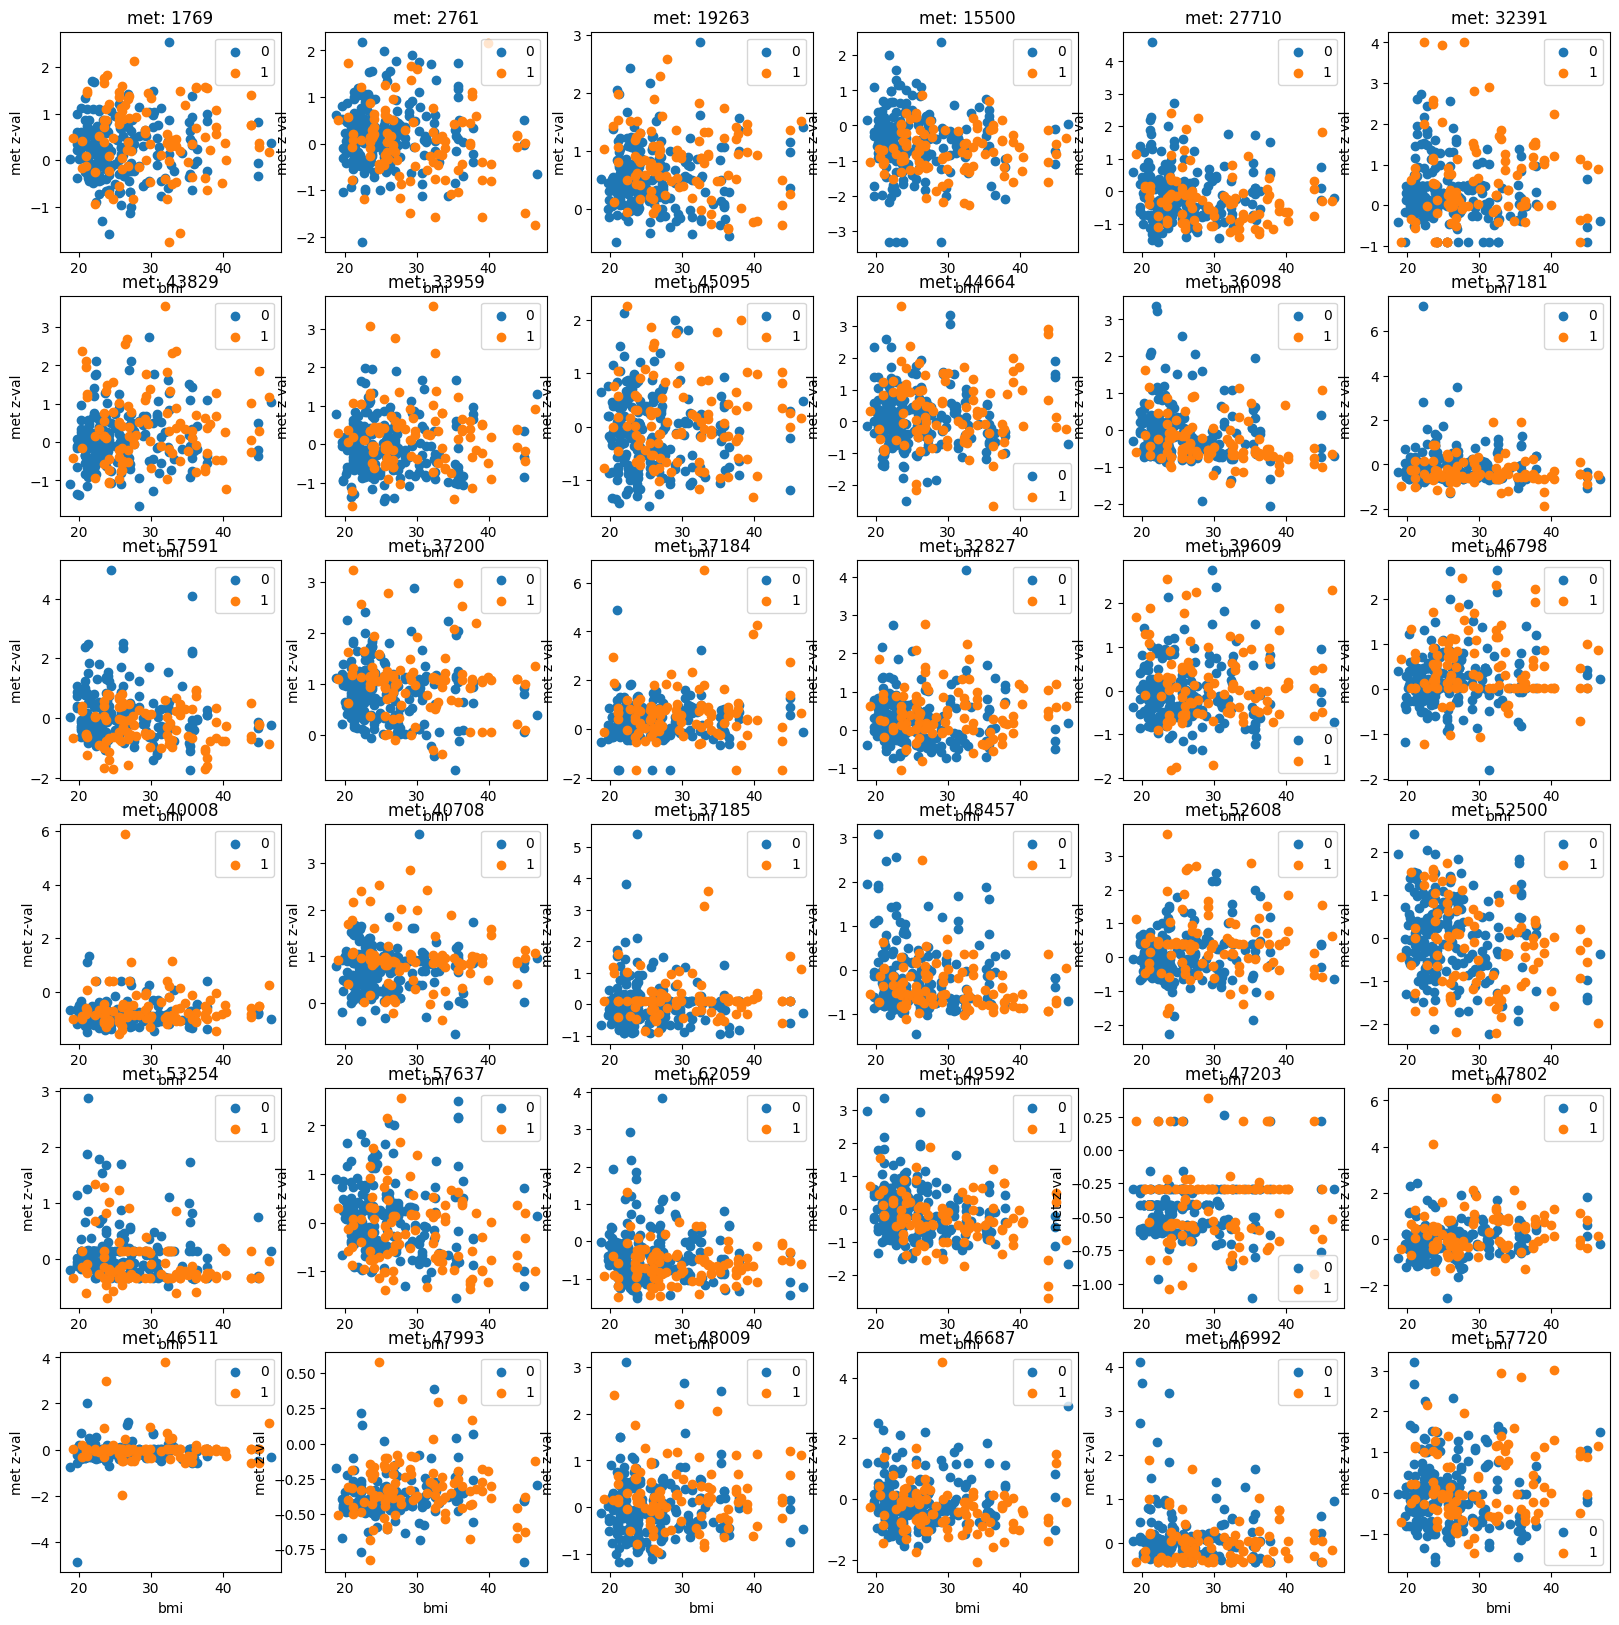

In [67]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(20, 20))
for met_id in importances_mrmr.keys():

    plt.subplot(6, 6, i)
    plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0])
    plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1])

    plt.legend([0, 1])
    plt.title(f'met: {met_id}')
    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
plt.show()

In [68]:
bmi_met_corr = test.corr()['BMI'][3:]

In [69]:
bmi_met_corr

1769     0.062543
2761    -0.107379
19263    0.024560
15500   -0.072013
27710   -0.116238
32391   -0.018595
43829    0.113343
33959    0.032421
45095    0.007113
44664    0.059923
36098   -0.207201
37181   -0.081540
57591   -0.111339
37200   -0.064032
37184    0.127090
32827    0.044905
39609    0.062124
46798    0.069546
40008    0.070840
40708    0.066879
37185    0.003091
48457   -0.132346
52608    0.093402
52500   -0.238707
53254   -0.171070
57637   -0.187596
62059   -0.080032
49592   -0.283999
47203    0.060113
47802    0.155597
46511    0.067211
47993    0.149238
48009    0.083932
46687   -0.007383
46992   -0.084641
57720    0.095691
Name: BMI, dtype: float64

In [70]:
bmi_met_corr.max()

0.15559689666268775

In [71]:
bmi_met_corr.min()

-0.28399944005109684

In [72]:
test1 = test[test.trimester == 1]

In [73]:
bmi_met_corr1 = test1.corr()['BMI'][3:]

In [74]:
bmi_met_corr1

1769     0.239587
2761     0.067300
19263    0.171422
15500   -0.161154
27710   -0.160178
32391   -0.082241
43829   -0.174282
33959    0.031701
45095    0.072731
44664   -0.057651
36098   -0.172939
37181   -0.099038
57591   -0.116508
37200    0.222079
37184    0.099761
32827    0.113144
39609    0.148253
46798    0.099319
40008    0.001642
40708    0.463460
37185   -0.004314
48457   -0.240986
52608    0.152820
52500   -0.097235
53254    0.045951
57637   -0.263323
62059   -0.113855
49592   -0.207707
47203    0.418307
47802    0.180038
46511    0.097399
47993    0.234527
48009    0.144322
46687   -0.082513
46992   -0.079169
57720    0.033331
Name: BMI, dtype: float64

In [75]:
bmi_met_corr1.max()

0.4634604787812966

In [76]:
bmi_met_corr1.argmax()

19

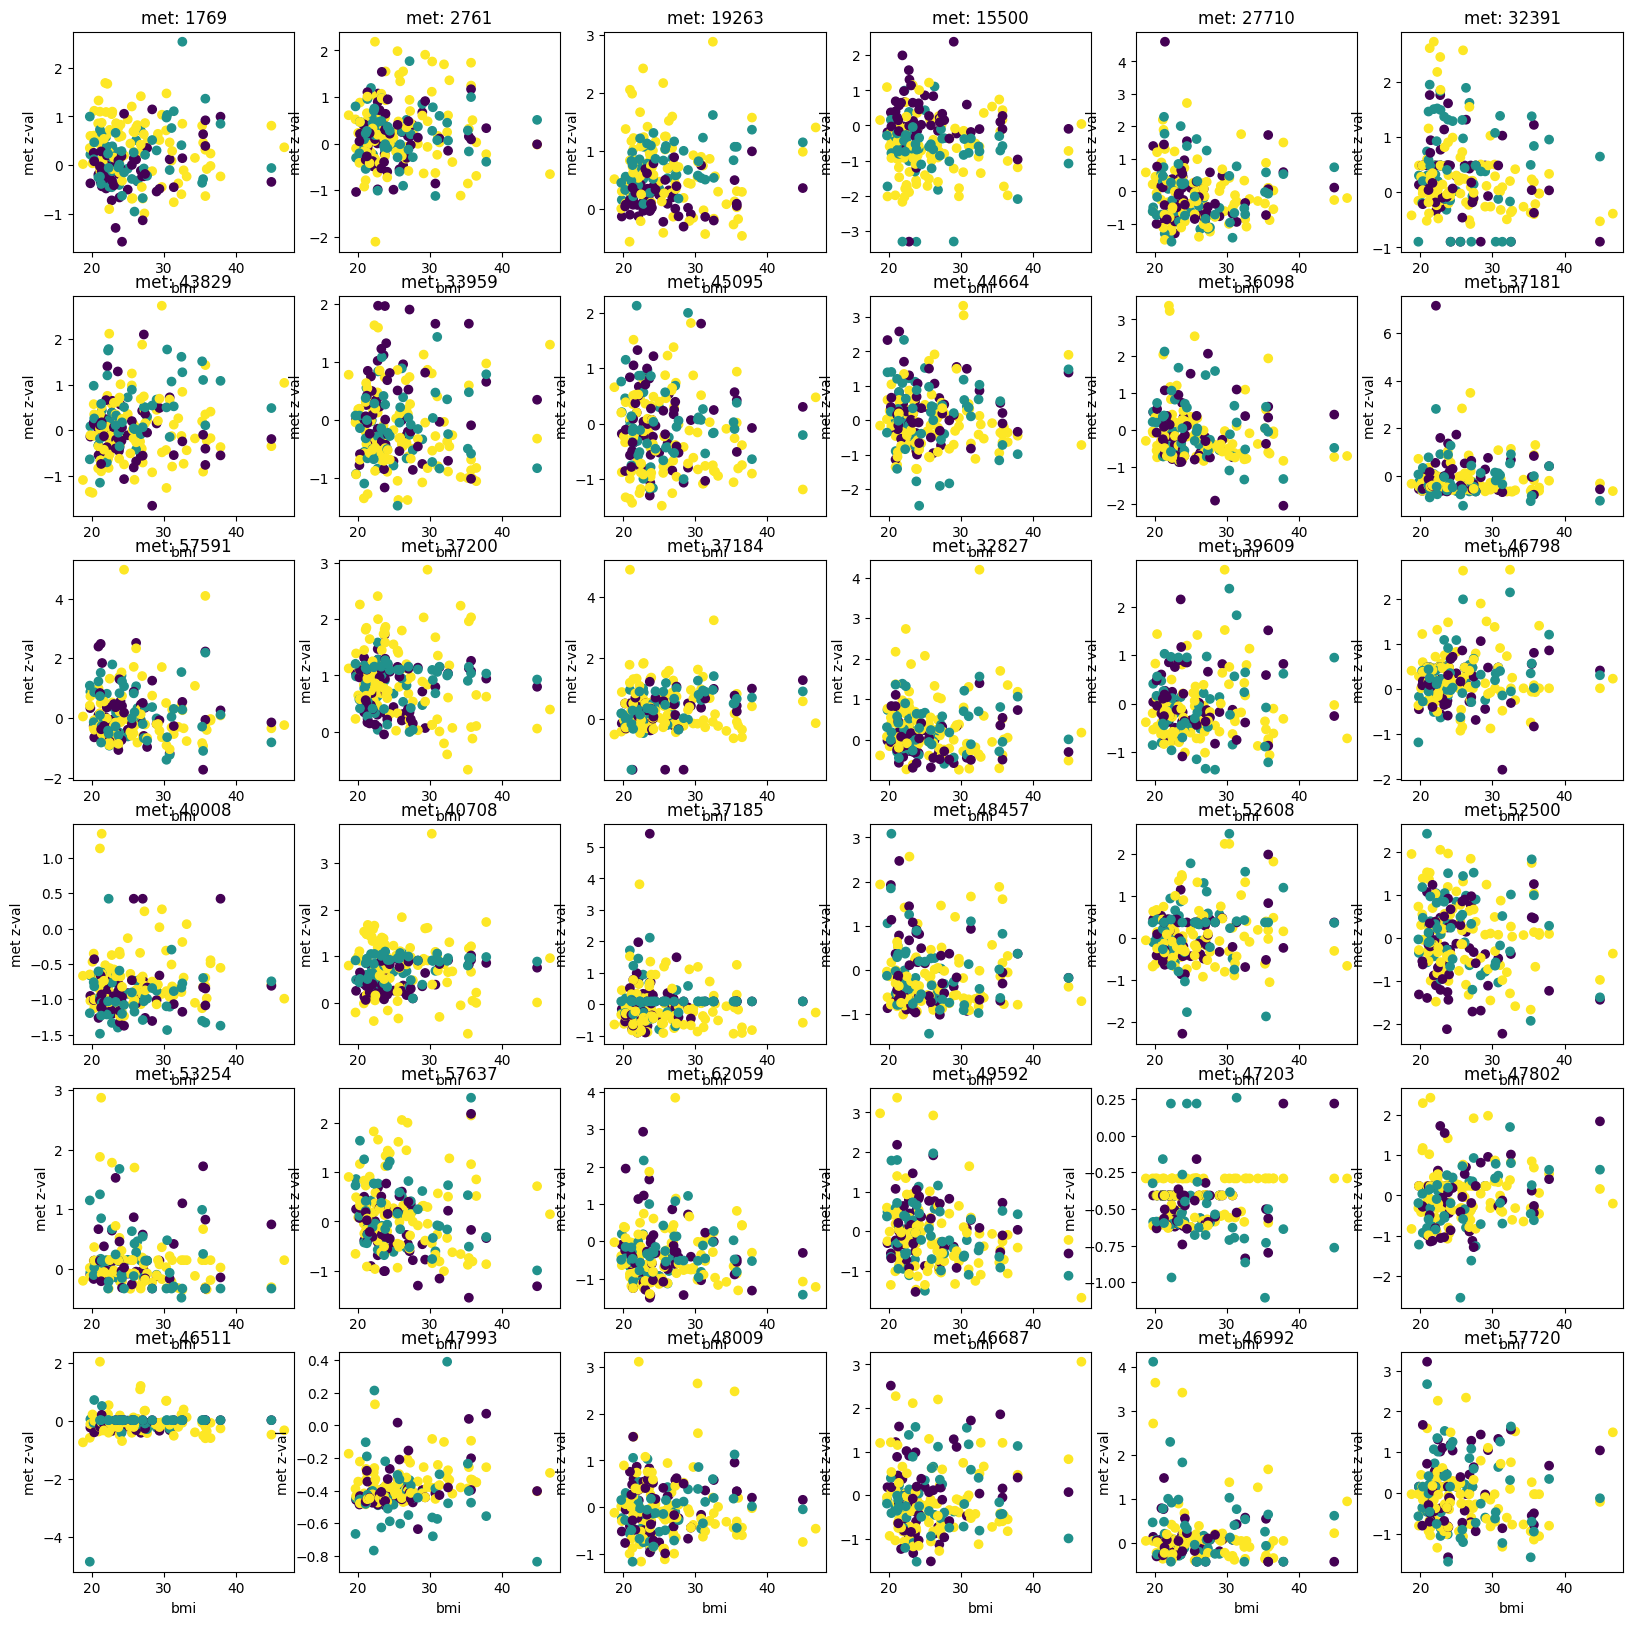

In [78]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(20, 20))
for met_id in importances_mrmr.keys():

    plt.subplot(6, 6, i)
    plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0], c=test[test.pe == 0].trimester)
#     plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1])

#     plt.legend([0, 1])
    plt.title(f'met: {met_id}')
    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
plt.show()

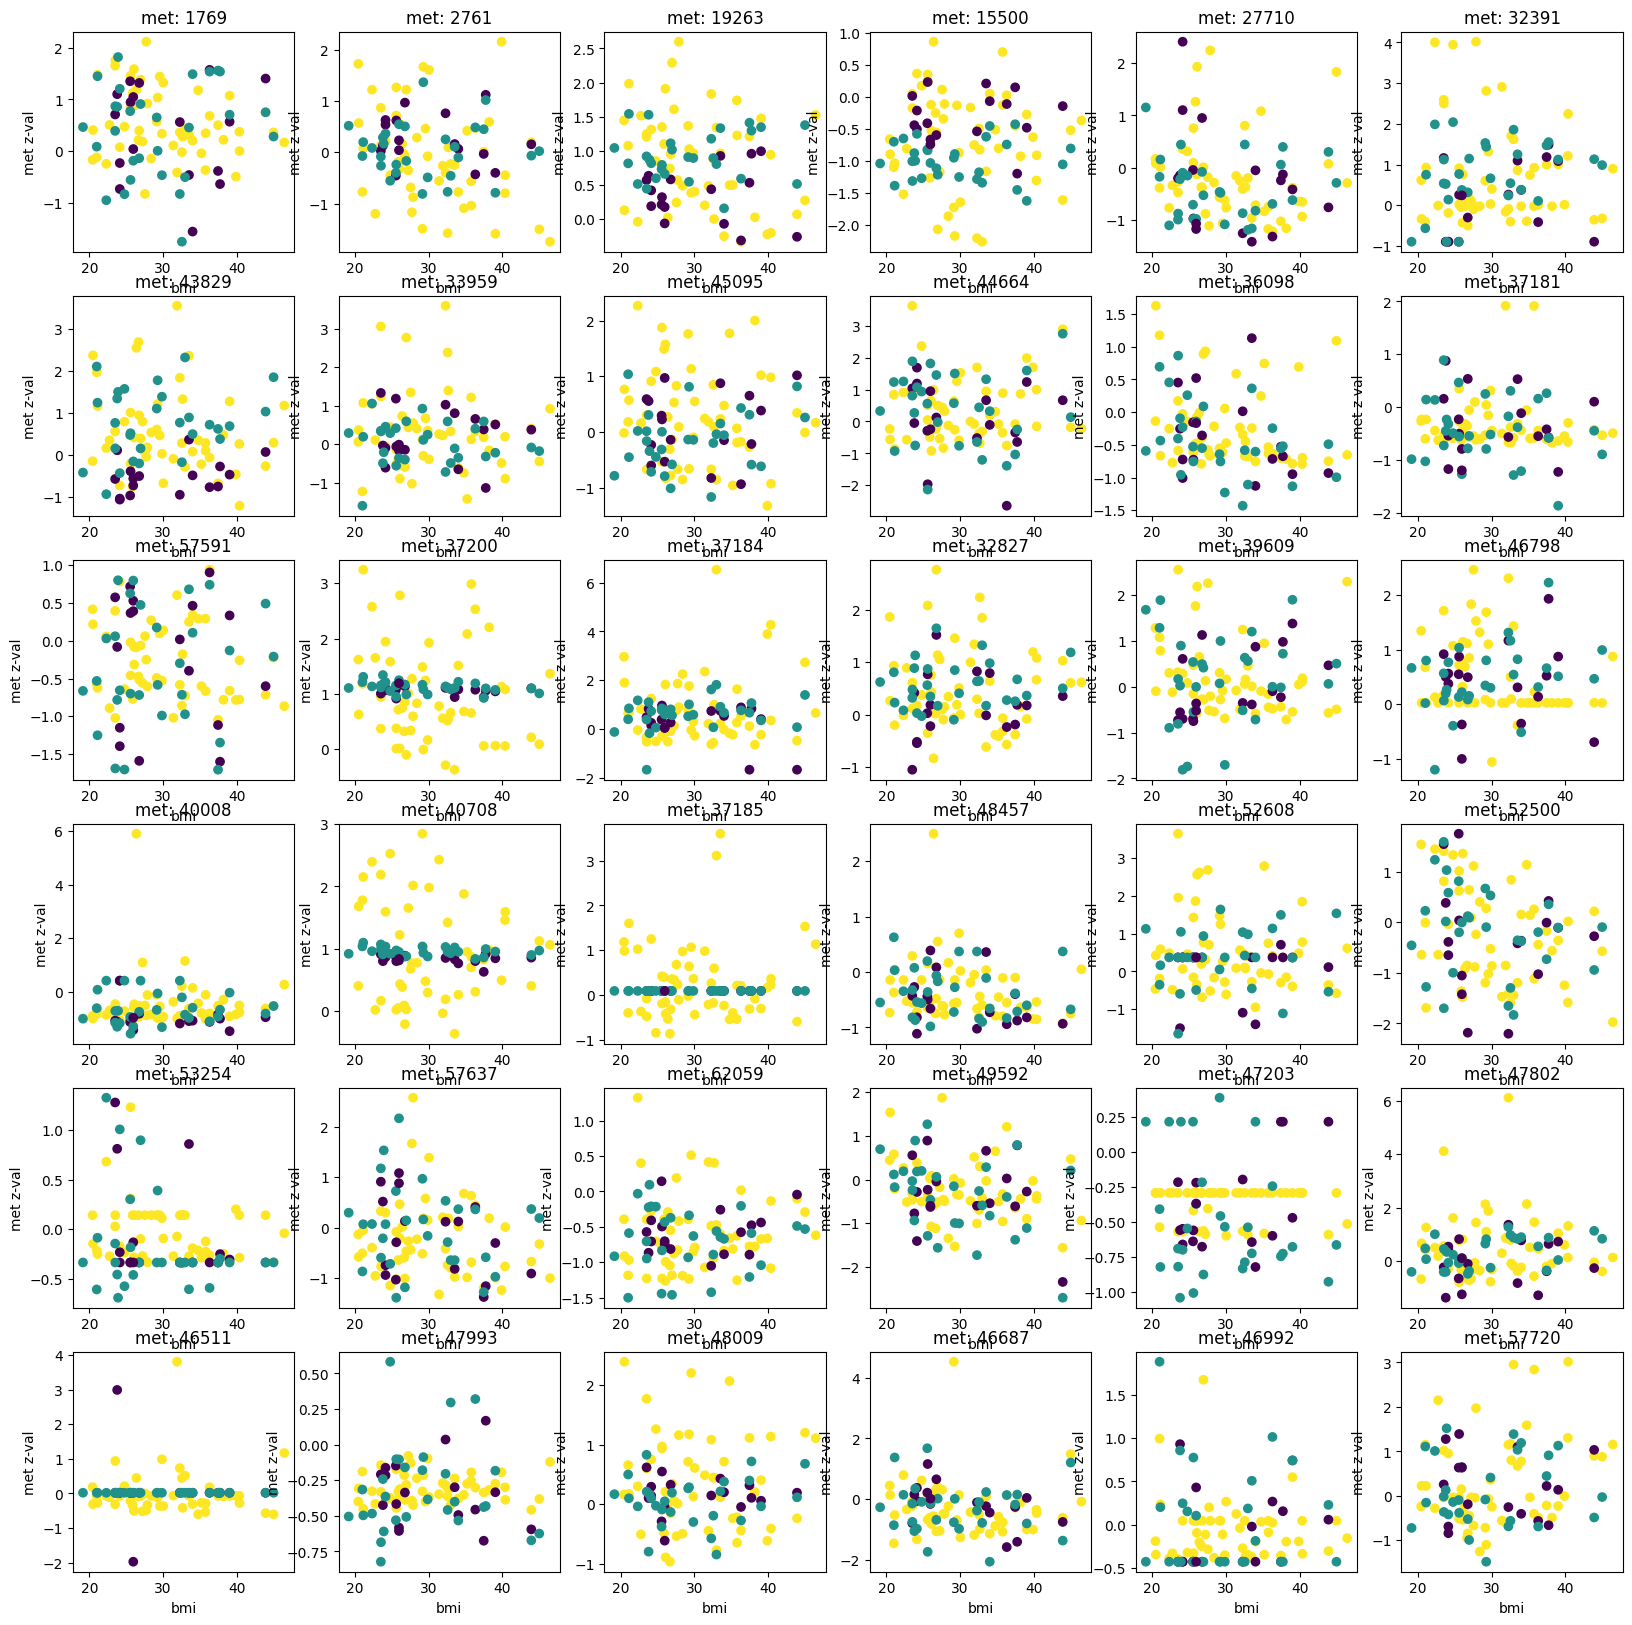

In [80]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(20, 20))
for met_id in importances_mrmr.keys():

    plt.subplot(6, 6, i)
#     plt.scatter(test.BMI[test.pe == 0], test[met_id][test.pe == 0], c=test[test.pe == 0].trimester)
    plt.scatter(test.BMI[test.pe == 1], test[met_id][test.pe == 1], c=test[test.pe == 1].trimester)

#     plt.legend([0, 1])
    plt.title(f'met: {met_id}')
    plt.xlabel('bmi')
    plt.ylabel('met z-val')
    i += 1
plt.show()

In [81]:
# da li postoje neki drugi metaboliti cija je koncentracije korelisana sa bmi?

In [82]:
test = clin_df[['trimester', 'sIDs', 'pe', 'BMI']].join(X, on='sIDs', how='right')
bmi_met_corr = test.corr()['BMI'][3:]

In [83]:
bmi_met_corr.max()

0.3629719520033358

In [84]:
bmi_met_corr.min()

-0.33050009839220845

In [85]:
# ne postoje vrednosti blizu 1/-1

In [86]:
inds = []
for t in range(1, 4):
    bmi_met_corr = test[test.trimester == t].corr()['BMI'][3:]
    inds += [bmi_met_corr.index[i] for i, x in enumerate(bmi_met_corr) if x > 0.5 or x < -0.5]
    print([(bmi_met_corr.index[i], x) for i, x in enumerate(bmi_met_corr) if x > 0.5 or x < -0.5])


[(18368, 0.6283242277770572), (46172, 0.5065154544661632), (62103, 0.6211635037728742), (54961, 0.5154344301159344)]
[]
[]


In [87]:
comp_df[comp_df.COMP_ID.isin(inds)]

BIOCHEMICAL  PATHWAY_SORTORDER  \
157                              cys-gly, oxidized              586.0   
452                  5alpha-pregnan-diol disulfate             3301.0   
486                    cysteinylglycine disulfide*              585.0   
727  oleoyl-arachidonoyl-glycerol (18:1/20:4) [2]*             2959.0   

    SUPER_PATHWAY             SUB_PATHWAY  COMP_ID   PLATFORM  CHEMICAL_ID  \
157    Amino Acid  Glutathione Metabolism    18368  Pos Early         1224   
452         Lipid      Progestin Steroids    46172        Neg    100002015   
486    Amino Acid  Glutathione Metabolism    62103  Pos Early    100002466   
727         Lipid          Diacylglycerol    54961   Pos Late    100010937   

             PUBCHEM         CAS KEGG                  HMDB_ID  
157           333293   7729-20-6  NaN                      NaN  
452  3082277,5127902         NaN  NaN  HMDB0240581,HMDB0240582  
486         22833544  70555-24-7  NaN              HMDB0000709  
727          9543786         NaN  NaN              HMDB0007228

In [88]:
# korelacija koncentracije metabolita sa staroscu:

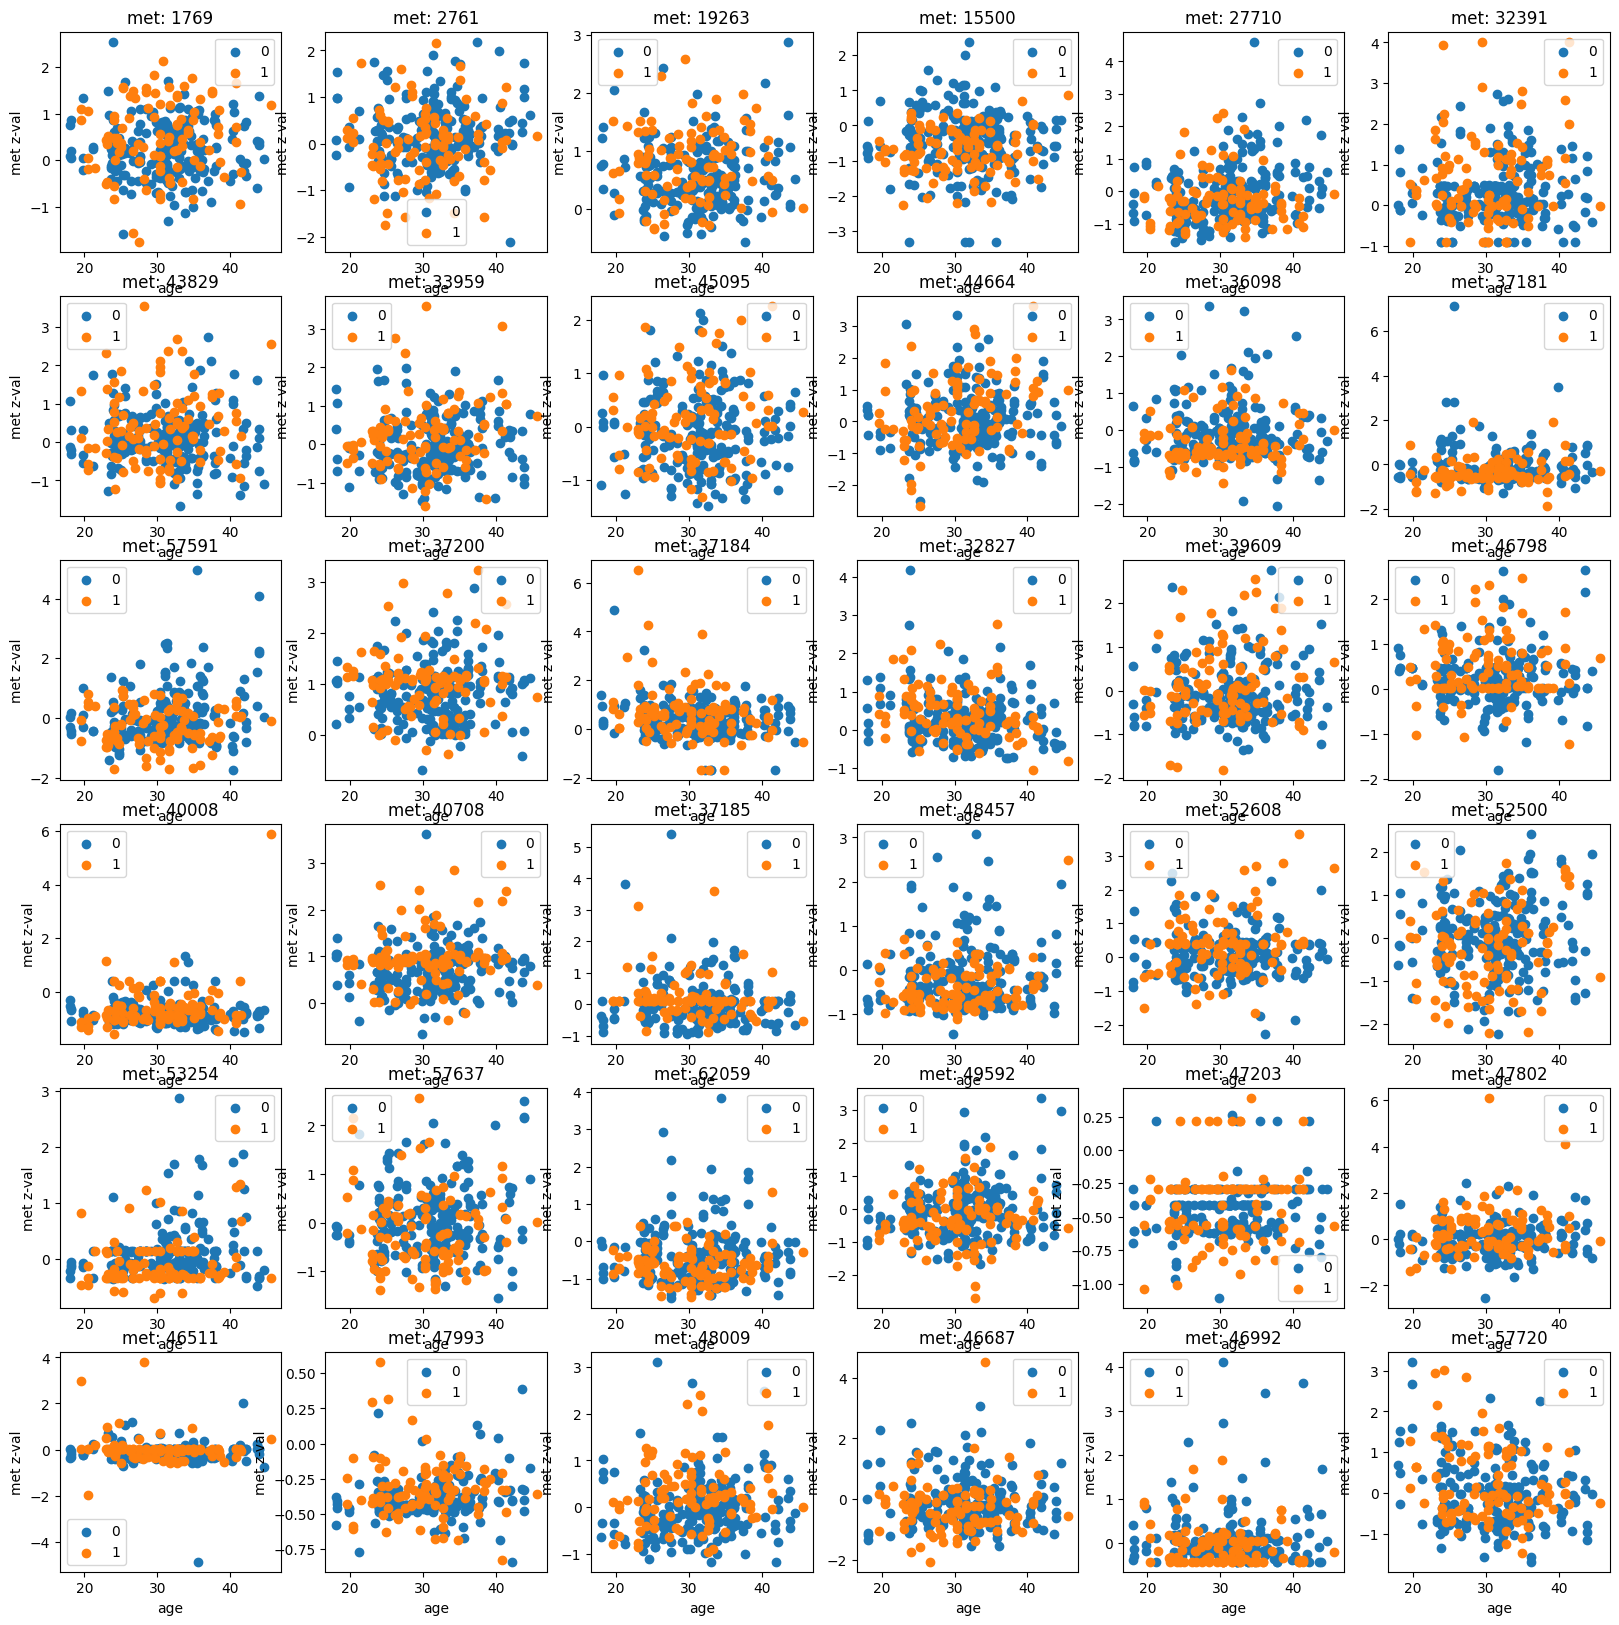

In [92]:
i = 1
test = clin_df[['trimester', 'sIDs', 'pe', 'age']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

plt.figure(figsize=(20, 20))
for met_id in importances_mrmr.keys():

    plt.subplot(6, 6, i)
    plt.scatter(test.age[test.pe == 0], test[met_id][test.pe == 0])
    plt.scatter(test.age[test.pe == 1], test[met_id][test.pe == 1])

    plt.legend([0, 1])
    plt.title(f'met: {met_id}')
    plt.xlabel('age')
    plt.ylabel('met z-val')
    i += 1
plt.show()

In [93]:
test.corr()['age'][3:]

1769     0.010653
2761     0.085877
19263    0.009244
15500    0.001348
27710    0.186141
32391    0.042419
43829   -0.010232
33959    0.094985
45095    0.030649
44664    0.122624
36098    0.026634
37181    0.030647
57591    0.193781
37200    0.033957
37184   -0.203060
32827   -0.208197
39609    0.068118
46798    0.033182
40008    0.078127
40708    0.086958
37185   -0.065930
48457    0.119681
52608    0.080969
52500    0.119115
53254    0.207958
57637    0.043256
62059    0.029587
49592    0.146322
47203    0.087921
47802    0.049131
46511   -0.081937
47993    0.052315
48009    0.073791
46687   -0.013591
46992   -0.002552
57720   -0.244069
Name: age, dtype: float64

In [94]:
test = clin_df[['trimester', 'sIDs', 'pe', 'age']].join(X, on='sIDs', how='right')

In [95]:
age_corr_df = test.corr()['age'][3:]

In [96]:
age_corr_df

42370    0.030723
485     -0.058232
27665    0.024405
38395    0.108393
437      0.080668
           ...   
57716    0.094012
57718   -0.333612
57719   -0.035628
57720   -0.244069
57754    0.010713
Name: age, Length: 948, dtype: float64

In [97]:
age_corr_df.min()

-0.48138604977259414

In [98]:
age_corr_df.max()

0.3144210024013628

In [99]:
for t in range(1, 4):
    bmi_met_corr1 = test[test.trimester == t].corr()['age'][3:]
    print(bmi_met_corr1.min(), bmi_met_corr1.max())

-0.49374329300466363 0.3936447403972269
-0.529669334691877 0.36888356090121294
-0.4617405240895046 0.3539845472442021


In [100]:
# clin_df = pd.read_csv('./metabolomics/sampleAttr.csv')

In [101]:
trimester_df = clin_df[['trimester', 'sIDs', 'pe', 'ptIDs']].join(X[importances_mrmr.keys()], on='sIDs', how='right')

In [102]:
trimester_plt = [(key, inds) for key, inds in trimester_df.groupby('ptIDs').groups.items() if len(inds) == 3]

In [108]:
# promena koncentracije izdvojenih metabolita tokom trimestara kod svake pacijentkinje posebno
# problem je to sto nema dovoljno pacijenata sa PE za sva tri trimestra

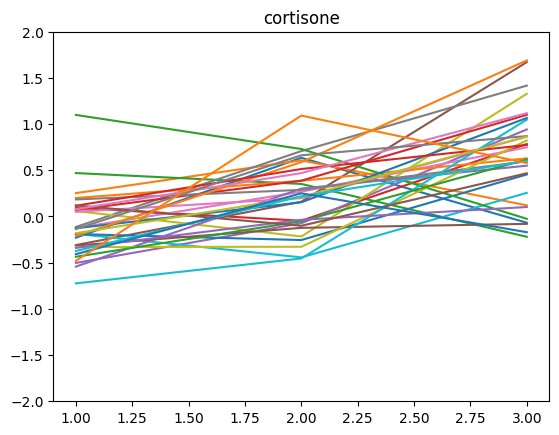

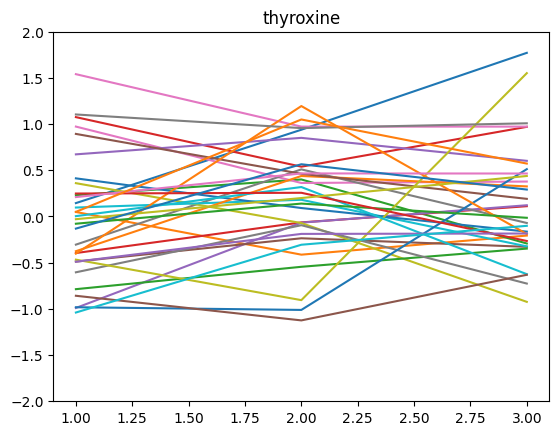

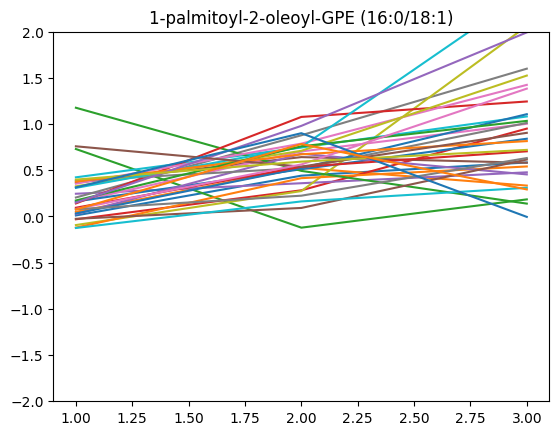

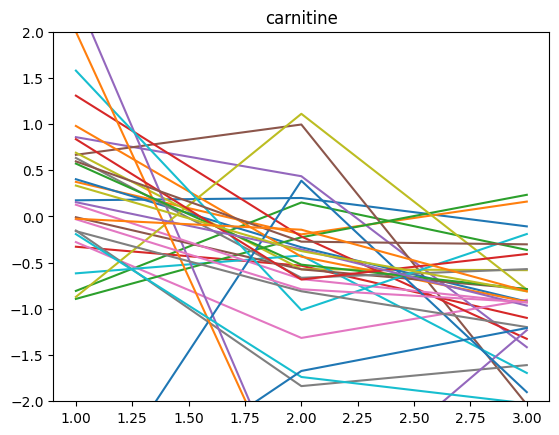

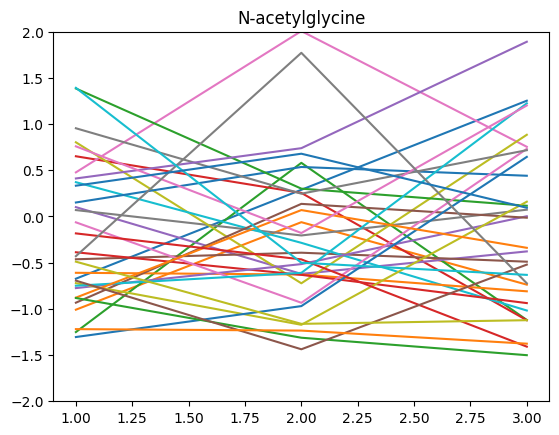

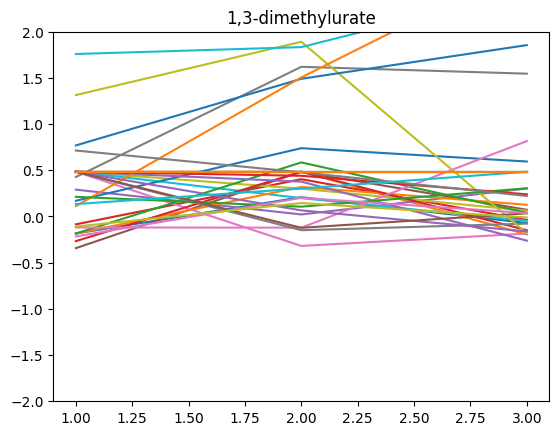

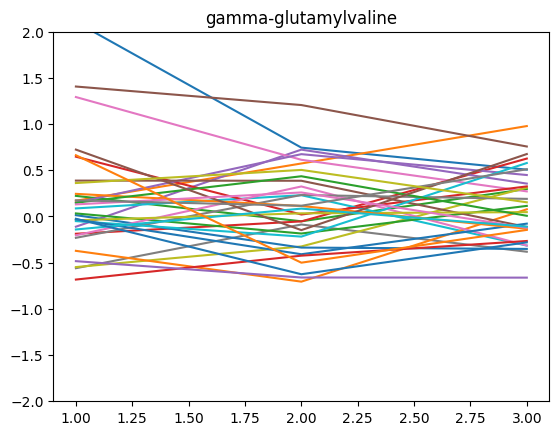

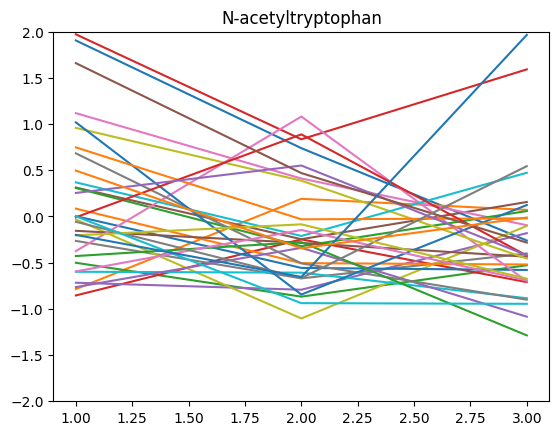

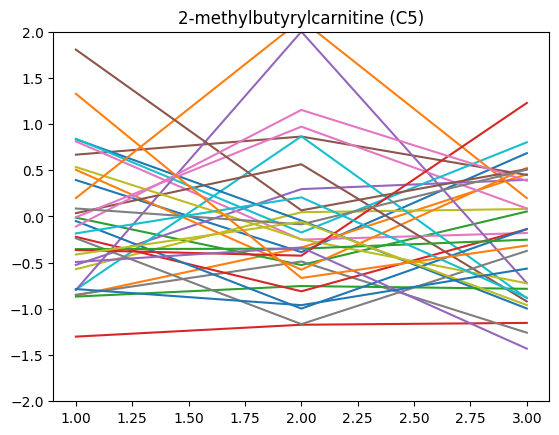

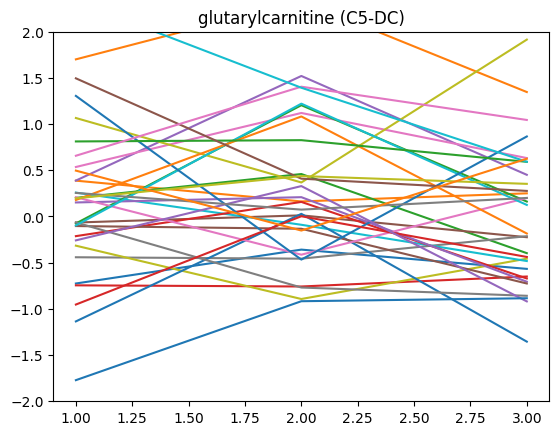

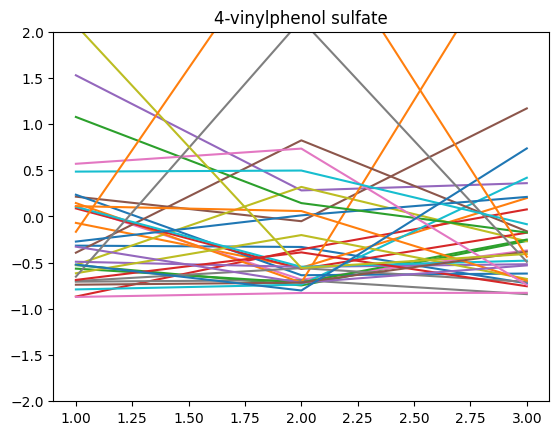

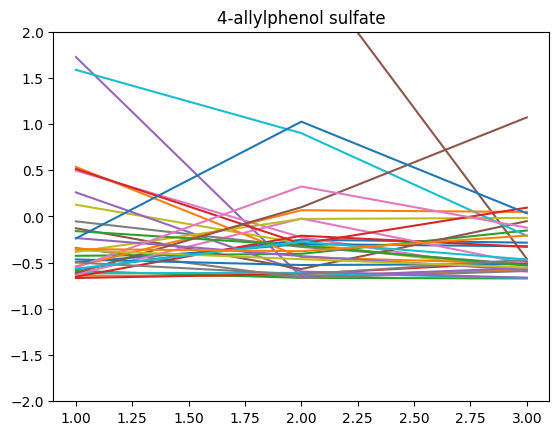

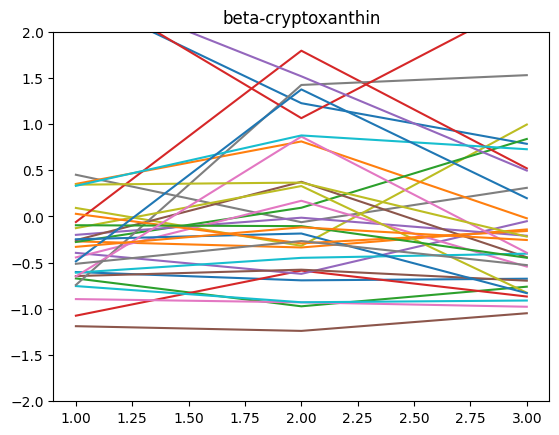

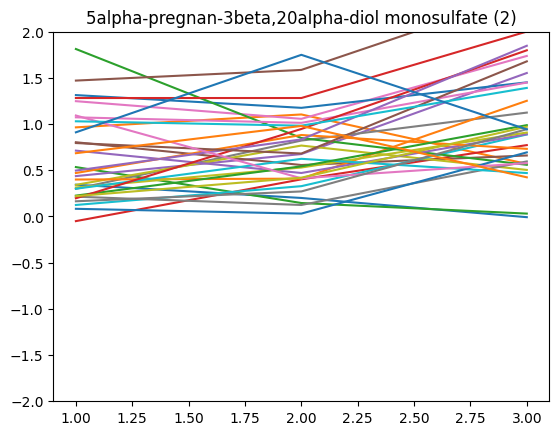

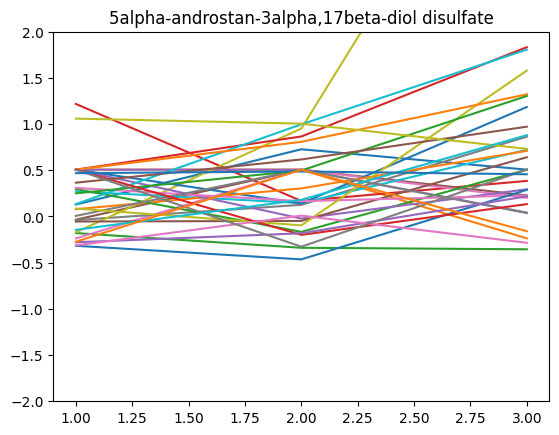

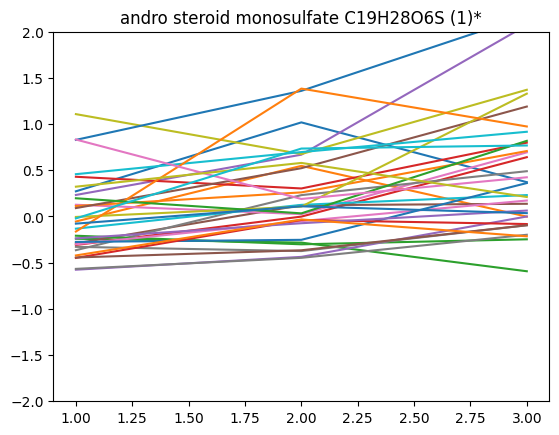

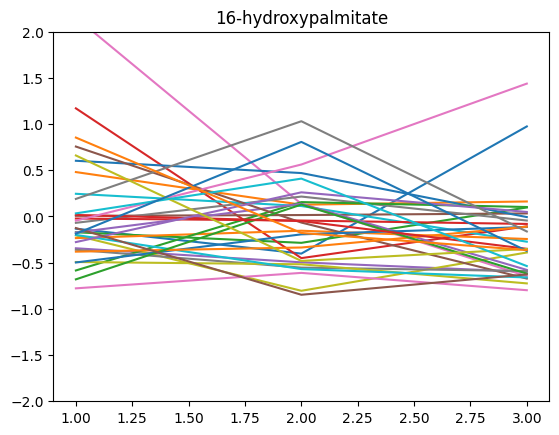

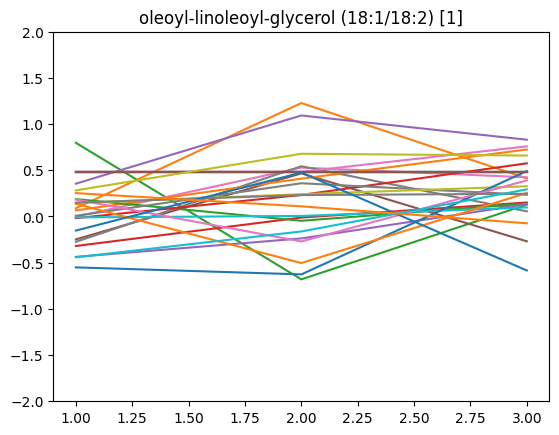

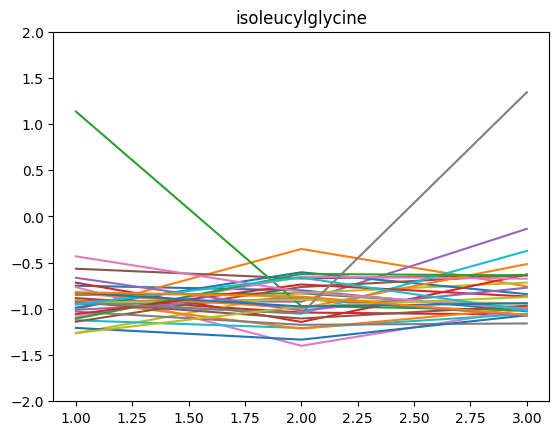

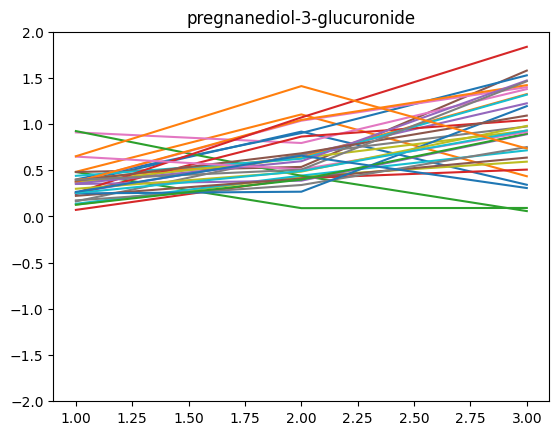

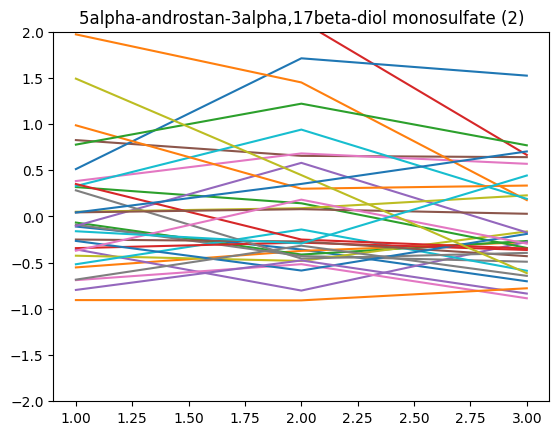

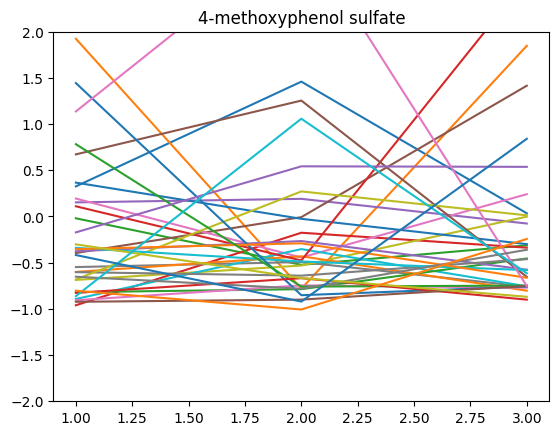

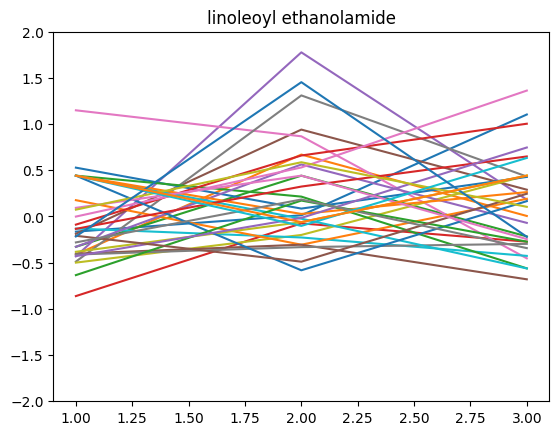

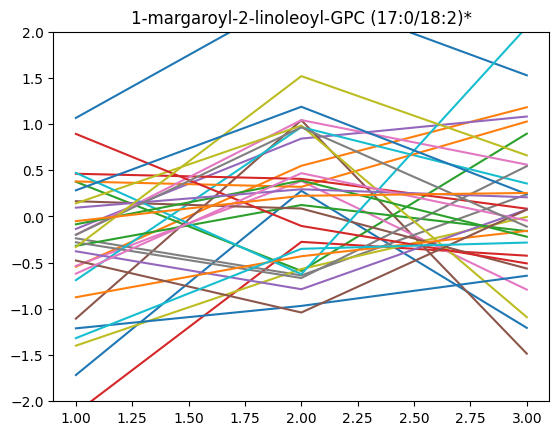

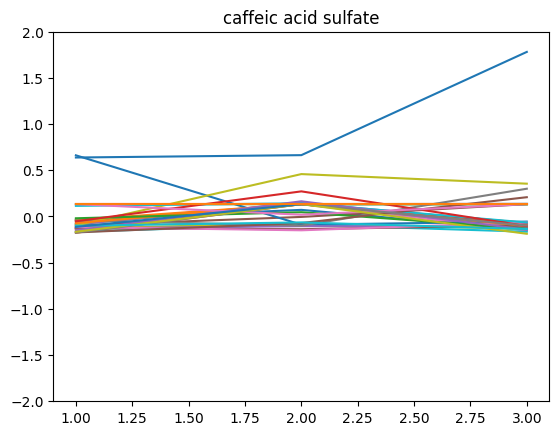

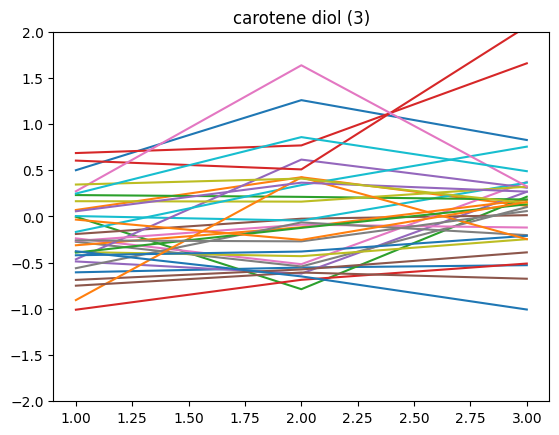

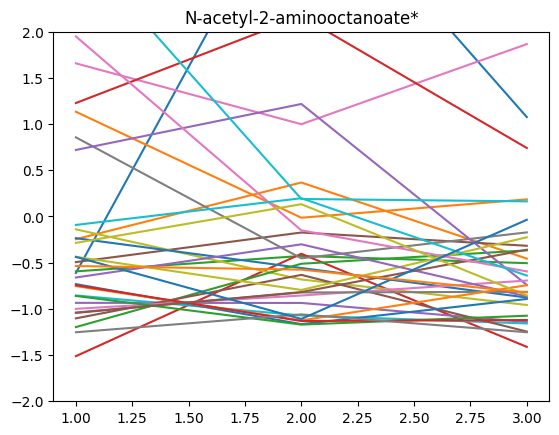

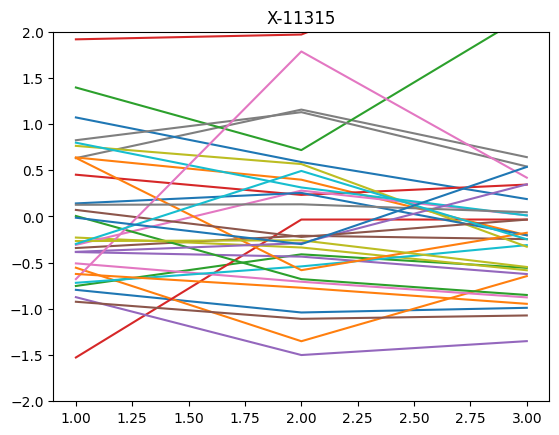

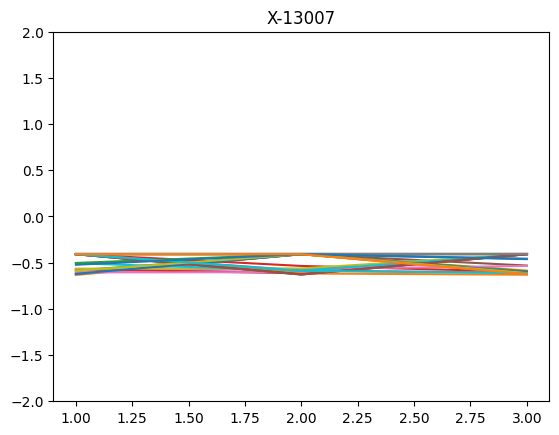

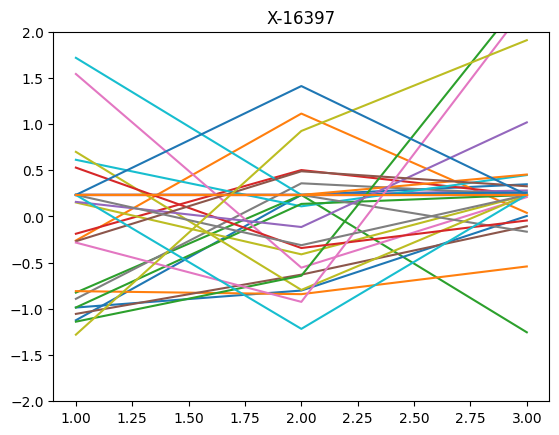

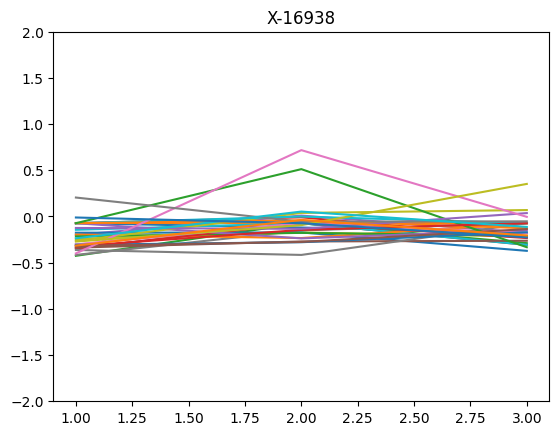

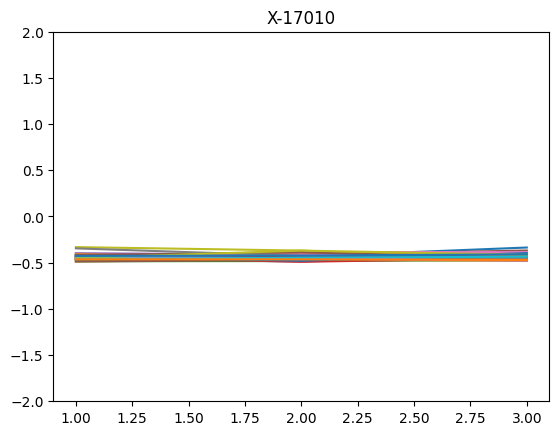

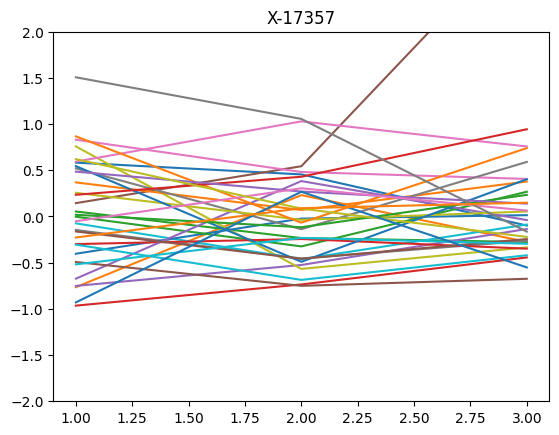

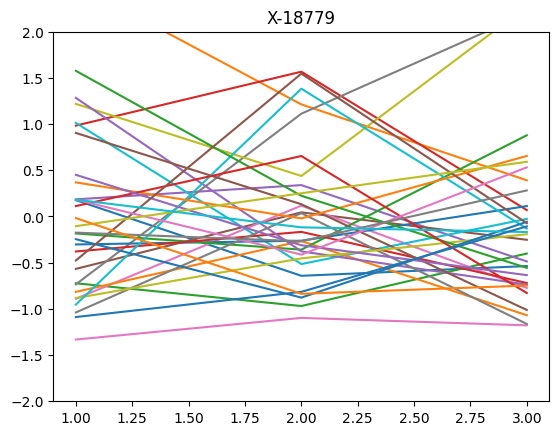

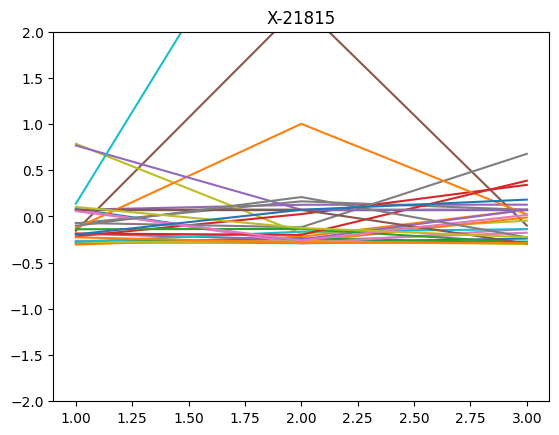

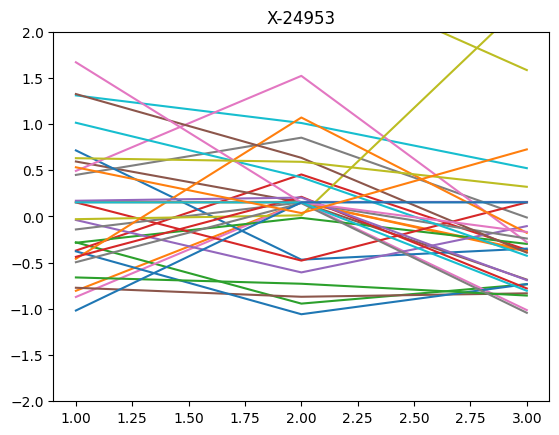

In [110]:
for met in importances_mrmr.keys():
    for p, inds in trimester_plt:

        y = [trimester_df.loc[inds[0]][met], trimester_df.loc[inds[1]][met], trimester_df.loc[inds[2]][met]]
        pe = trimester_df.loc[inds[0]].pe
        if(pe == 0):
            plt.plot([1, 2, 3], y)
    plt.ylim(-2, 2)
    [name] = comp_df[comp_df.COMP_ID == met].BIOCHEMICAL
    plt.title(name)
    plt.show()